In [47]:
from pathlib import Path
import shutil
from tqdm import tqdm
from useYolo import get_xyxy as detect_img
from Detector_show4d import Detector
import model as qrcnn_model
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import copy
from PIL import Image
import numpy as np
from scipy.signal import savgol_filter
%matplotlib inline

In [39]:
def xyxyBox_IOU(boxA, boxB):
    # 使用 xyxy 座標，單位統一即可
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    print(xA,yA)
    print(xB,yB)
    # 計算兩個正方形的交集面積
    interArea = max(0, xB - xA + 0) * max(0, yB - yA + 0)
    print(interArea)
    # 分別計算兩個正方形的面積
    boxAArea = (boxA[2] - boxA[0] + 0) * (boxA[3] - boxA[1] + 0)
    boxBArea = (boxB[2] - boxB[0] + 0) * (boxB[3] - boxB[1] + 0)
    # 交集 / 聯集
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [42]:
xyxyBox_IOU((2,1,5,5), (2,1,7,7))

2 1
5 5
12


0.4

In [54]:
# 基於用 lagelimg 標記好的 txt 檔名，去將原始圖片目錄下的東西 複製到 新的資料夾

base_root = r"D:\Git\zjpj\data_clean\yolo_label_NOT_IN_the_real593_DATASET"  # 所需的標記檔案 txt
image_src = r"D:\Git\zjpj\data_clean\NOT_IN_the_real593_DATASET" # 圖片目錄，檔案數量會 >= base_root
dst_path = r"D:\Git\zjpj\data_clean\IoU_test_image"  # 要將圖片複製到的目的

image_stem = [ Path(_).stem for _ in glob(image_src+'/*.*')]
labels = glob(base_root+'/*.*')
labels.pop() # remove last one.

for _ in labels:
    label_stem = Path(_).stem
    if label_stem in image_stem:
        # cpoy image
        shutil.copy2(Path(image_src).joinpath(f"{label_stem}.png"),
                    Path(dst_path).joinpath(f"{label_stem}.png"))
        # copy label
        # shutil.copy2(Path(label_src).joinpath(f"{label_stem}.txt"),
        #             Path(dst_path).joinpath(f"{label_stem}.txt"))

In [2]:
def get_ground_truth_norm_bbox(image_path, label_root=r"D:\Git\zjpj\data_clean\yolo_label_NOT_IN_the_real593_DATASET"):
    label_path = Path(label_root).joinpath(Path(image_path).stem+'.txt')
    assert os.path.isfile(label_path)
    bbox = []
    with open(label_path, mode='r') as f:
        contents = [_.rstrip()for _ in f.readlines()]
        
        for i in contents:
            _,x,y,w,h = [float(_) for _ in i.split(' ')]
            x1 = x-(w/2)
            y1 = y-(h/2)
            x2 = x+(w/2)
            y2 = y+(h/2)
            bbox.append((x1,y1,x2,y2))
    
    return bbox
#
get_ground_truth_norm_bbox(r"D:\Git\zjpj\data_clean\IoU_test_image\00053.png")

[(0.07446749999999999, 0.16763, 0.2411345, 0.442196),
 (0.41844, 0.173411, 0.58688, 0.445087),
 (0.760638, 0.16763, 0.932624, 0.442196)]

In [3]:
def imread2ndarray(image_path):
    # 讀取的就算是 8bit 灰階，他也會傳回 3通道的 color_image
    return cv2.imread(image_path)

BOX_B=(255,0,0)  # BGR
BOX_G=(0,255,0)  # BGR
BOX_R=(0,0,255)  # BGR
BOX_K=(0,0,0)
def draw_norm_xyxybox_on_ndimage(bboxes, image, color, thickness=None):
    """
    在給定的 iamge 副本上畫bbox，
    其中 bbox 為 xyxy, 且為 正歸化過的float。
    """
    image = copy.deepcopy(image)
    w,h = image.shape[1::-1]
    if not thickness:
        thickness = max(w,h) // 150
    for bbox in bboxes:
        x1,y1,x2,y2 = bbox
        x1,y1,x2,y2 = int(x1*w),int(y1*h),int(x2*w),int(y2*h)
        image = cv2.rectangle(image, (x1,y1), (x2,y2), color, thickness)
    return image

In [48]:
IOU_estm_root = r'D:\Git\zjpj\data_clean\IoU_test_image'

# 初始化舊的模型
old_detector = Detector(weight="./50weight.pt", save_folder="./JUPYTER_LAB_TMP_LOG",
             net=qrcnn_model.QRCode_CNN())

In [42]:
sum(csv_record_n)/len(csv_record_o)

0.9005142736620877

In [41]:
sum(csv_record_o)/len(csv_record_o)

0.610868952177771

In [49]:
label_root=r"D:\Git\zjpj\data_clean\yolo_label_NOT_IN_the_real593_DATASET"

old_cnt = 0
bad_image = []

csv_record_n = []
csv_record_o = []
pbar = tqdm(glob(IOU_estm_root+'/*.*'), ncols=110)
bbox_result = []
for idx, image_path in enumerate(pbar):
    pbar.set_description(f"current:{image_path}")
    new_bbox = [res[0:4] for res in detect_img(image_path,norm=True)]  # 取 0,1,2,3 ， 4,5 是 pres and classes
    old_bbox = old_detector.detect_nrom_bbox(image_path)
    gdt_bbox = get_ground_truth_norm_bbox(image_path, label_root)
    print(new_bbox)
    print(old_bbox)
    print(gdt_bbox)
    
    n_iou = []
    o_iou = []
    for gx1,gy1,gx2,gy2 in gdt_bbox:  # 全部的 GT bbox
        #n_max_IOU
        for nx1,ny1,nx2,ny2 in new_bbox:  # 與 強化過模型的 bbox 做 iou比較
            iou = old_detector.xyxyBox_IOU((nx1,ny1,nx2,ny2),(gx1,gy1,gx2,gy2))
            # if iou > n_max_IOU:
            #     n_max_IOU = iou
            n_iou.append(iou)
        
        #o_max_IOU = 0.0
        for ox1,oy1,ox2,oy2 in old_bbox:  # 與 舊模型的 bbox 做 iou比較
            iou = old_detector.xyxyBox_IOU((ox1,oy1,ox2,oy2),(gx1,gy1,gx2,gy2))
            # if iou > o_max_IOU:
            #     o_max_IOU = iou
        
            o_iou.append(iou)
    
    image = imread2ndarray(image_path)
    # draw 3 type bboxes
    image = draw_norm_xyxybox_on_ndimage(gdt_bbox, image, BOX_G)
    image = draw_norm_xyxybox_on_ndimage(new_bbox, image, BOX_B)
    image = draw_norm_xyxybox_on_ndimage(old_bbox, image, BOX_R)
    
    n_iou_res = sum(n_iou)/len(n_iou) if len(n_iou) != 0 else 0
    csv_record_n.append(n_iou_res)
    o_iou_res = sum(o_iou)/len(o_iou) if len(o_iou) != 0 else 0
    csv_record_o.append(o_iou_res)
    print("avg NEW iou:", n_iou_res)
    print("avg OLD iou:", o_iou_res)
    image_stem = Path(image_path).stem
    
    cv2.imwrite("./JUPYTER_LAB_TMP_LOG/{}_N-{:.2f}_O-{:.2f}.jpg".format(image_stem, n_iou_res,o_iou_res),  image)
    if len(o_iou) == 0.0:
        bad_image.append(image_path)
    elif sum(o_iou)/len(o_iou) == 0.0:
        bad_image.append(image_path)
    elif len(new_bbox) == 0:
        bad_image.append(image_path)
    # 先驗條件 .72 .90
    elif o_iou_res < 0.65:
        bad_image.append(image_path)
    elif n_iou_res < 0.89:
        bad_image.append(image_path)
    #先驗條件 .72 .90
    else:
        print("===============================================")
        
print("cnt:", old_cnt)
print("bad name:", bad_image)
    

current:D:\Git\zjpj\data_clean\IoU_test_image\00005.png:   1%|                | 1/150 [00:00<00:16,  9.12it/s]

[(0.37666666666666665, 0.396969696969697, 0.62, 0.6848484848484848)]
[(0.36, 0.4008097165991903, 0.7022222222222222, 0.7125506072874493)]
[(0.37666700000000003, 0.409091, 0.6166670000000001, 0.693939)]
avg NEW iou: 0.9162363887529857
avg OLD iou: 0.6407999028503967


current:D:\Git\zjpj\data_clean\IoU_test_image\00008.png:   1%|▏               | 2/150 [00:00<00:35,  4.19it/s]

[(0.2725, 0.49333333333333335, 0.7675, 0.8233333333333334)]
[(0.36, 0.14666666666666667, 0.4911111111111111, 0.22074074074074074), (0.8, 0.14666666666666667, 0.9111111111111111, 0.22074074074074074), (0.02, 0.6266666666666667, 0.09111111111111111, 0.674074074074074), (0.0, 0.72, 0.07111111111111111, 0.7674074074074074), (0.6, 0.76, 0.7311111111111112, 0.8474074074074074), (0.0, 0.7866666666666666, 0.07111111111111111, 0.8340740740740741)]
[(0.2475, 0.4783335, 0.7925, 0.8416665000000001)]
avg NEW iou: 0.8249313182182786
avg OLD iou: 0.008978073177928644
[(0.14, 0.10285714285714286, 0.8828571428571429, 0.88)]
[(0.10305343511450382, 0.13740458015267176, 0.7404580152671756, 0.8778625954198473)]
[(0.09428550000000002, 0.08571450000000003, 0.9114285, 0.8971435)]
avg NEW iou: 0.8706780050758323
avg OLD iou: 0.7118148247103058


current:D:\Git\zjpj\data_clean\IoU_test_image\00018.png:   3%|▍               | 4/150 [00:00<00:23,  6.23it/s]

[(0.2570921985815603, 0.29521276595744683, 0.5620567375886525, 0.7553191489361702)]
[(0.5531914893617021, 0.0, 0.6288416075650118, 0.11347517730496454), (0.2553191489361702, 0.2872340425531915, 0.5862884160756501, 0.7836879432624113)]
[(0.2482265, 0.2898935, 0.5709215, 0.7606385)]
avg NEW iou: 0.9236972464252379
avg OLD iou: 0.4430909475836394
[(0.23666666666666666, 0.24, 0.7466666666666667, 0.7533333333333333), (0.5766666666666667, 0.4666666666666667, 1.0, 1.0)]
[(0.2, 0.24, 0.7822222222222223, 0.7422222222222222)]
[(0.24333349999999998, 0.23333349999999997, 0.7800005, 0.7566665)]
avg NEW iou: 0.5203058402822683
avg OLD iou: 0.8873742876641831


current:D:\Git\zjpj\data_clean\IoU_test_image\00027.png:   4%|▋               | 6/150 [00:00<00:19,  7.49it/s]

[(0.5559502664298401, 0.42033898305084744, 0.7015985790408525, 0.688135593220339)]
[(0.5545023696682464, 0.3665158371040724, 0.7156398104265402, 0.7149321266968326)]
[(0.5488455, 0.40677949999999996, 0.7158085, 0.7118645)]
avg NEW iou: 0.7657190254237339
avg OLD iou: 0.8487646131000365


current:D:\Git\zjpj\data_clean\IoU_test_image\00032.png:   5%|▋               | 7/150 [00:01<00:23,  6.08it/s]

[(0.002, 0.0, 1.0, 0.9839679358717435)]
[(0.048, 0.1925133689839572, 0.9253333333333333, 1.0240641711229947)]
[(0.07800000000000001, 0.07615250000000001, 0.9339999999999999, 0.9238474999999999)]
avg NEW iou: 0.7389276171079427
avg OLD iou: 0.7417006936513065


current:D:\Git\zjpj\data_clean\IoU_test_image\00044.png:   5%|▊               | 8/150 [00:01<00:28,  4.90it/s]

[(0.3233333333333333, 0.25210084033613445, 0.845, 0.7680672268907563)]
[(0.1, 0.0, 0.3511111111111111, 0.273542600896861)]
[(0.29833350000000003, 0.2403365, 0.8650005000000001, 0.7831935000000001)]
avg NEW iou: 0.8749860568476839
avg OLD iou: 0.004678973946328927


current:D:\Git\zjpj\data_clean\IoU_test_image\00045.png:   6%|▉               | 9/150 [00:01<00:32,  4.29it/s]

[(0.5886524822695035, 0.5319148936170213, 0.7801418439716312, 0.7163120567375887)]
[(0.3191489361702128, 0.2978723404255319, 0.7990543735224587, 0.735224586288416)]
[(0.585106, 0.5248225, 0.783688, 0.7251775)]
avg NEW iou: 0.8874805042413326
avg OLD iou: 0.18956276457277843


current:D:\Git\zjpj\data_clean\IoU_test_image\00049.png:   7%|█              | 11/150 [00:02<00:53,  2.61it/s]

[(0.19863013698630136, 0.33, 0.7808219178082192, 0.6083333333333333)]
[(0.2, 0.33116883116883117, 0.7911111111111111, 0.6093073593073594)]
[(0.19520549999999998, 0.3250005, 0.7945205, 0.6133335)]
avg NEW iou: 0.9377385983624358
avg OLD iou: 0.9514386216050627
[(0.19858156028368795, 0.05543237250554324, 0.8705673758865248, 0.9600886917960089), (0.5691489361702128, 0.0, 0.9929078014184397, 0.5365853658536586)]
[(0.425531914893617, 0.0, 0.5224586288416075, 0.12130177514792899), (0.48936170212765956, 0.15976331360946747, 0.6501182033096927, 0.3875739644970414), (0.14893617021276595, 0.3727810650887574, 0.35224586288416077, 0.6272189349112426), (0.5319148936170213, 0.4260355029585799, 0.6713947990543735, 0.5739644970414202)]
[(0.1507095, 0.048780500000000004, 0.8581565, 0.9445675)]
avg NEW iou: 0.5454303272646795
avg OLD iou: 0.04555403985203879


current:D:\Git\zjpj\data_clean\IoU_test_image\00050.png:   7%|█              | 11/150 [00:02<00:53,  2.61it/s]

[(0.5539906103286385, 0.6316666666666667, 0.9014084507042254, 0.8716666666666667), (0.04460093896713615, 0.6666666666666666, 0.4413145539906103, 0.9666666666666667), (0.07276995305164319, 0.055, 0.4014084507042254, 0.27666666666666667), (0.08685446009389672, 0.37166666666666665, 0.3779342723004695, 0.5733333333333334), (0.47417840375586856, 0.006666666666666667, 0.9553990610328639, 0.33)]
[(0.58, 0.014218009478672985, 0.6511111111111111, 0.06477093206951026), (0.58, 0.6255924170616114, 0.9111111111111111, 0.8894154818325435), (0.16, 0.7393364928909952, 0.3711111111111111, 0.9036334913112164)]
[(0.056338, 0.05166700000000002, 0.401408, 0.286667), (0.474178, 0.010000499999999996, 0.950704, 0.31833350000000005), (0.07277, 0.365, 0.403756, 0.585), (0.5563385000000001, 0.6199995, 0.9225355, 0.8816664999999999), (0.04694799999999999, 0.6633330000000001, 0.450704, 0.968333)]
avg NEW iou: 0.1785316353450786
avg OLD iou:

current:D:\Git\zjpj\data_clean\IoU_test_image\00053.png:   8%|█▏             | 12/150 [00:03<00:54,  2.53it/s]

 0.07786074644087057
[(0.07801418439716312, 0.17052023121387283, 0.2393617021276596, 0.430635838150289), (0.4237588652482269, 0.17341040462427745, 0.5833333333333334, 0.43641618497109824)]
[(0.0851063829787234, 0.138996138996139, 0.26713947990543735, 0.4362934362934363), (0.7872340425531915, 0.17374517374517376, 0.9479905437352246, 0.4362934362934363), (0.425531914893617, 0.24324324324324326, 0.5011820330969267, 0.3667953667953668), (0.2127659574468085, 0.555984555984556, 0.28841607565011823, 0.6795366795366795)]


current:D:\Git\zjpj\data_clean\IoU_test_image\00061.png:   9%|█▍             | 14/150 [00:03<00:38,  3.57it/s]

[(0.07446749999999999, 0.16763, 0.2411345, 0.442196), (0.41844, 0.173411, 0.58688, 0.445087), (0.760638, 0.16763, 0.932624, 0.442196)]
avg NEW iou: 0.30571029269539257
avg OLD iou: 0.1393518519941359
[(0.325044404973357, 0.1066350710900474, 0.6625222024866785, 0.566350710900474)]
[(0.2985781990521327, 0.08544303797468354, 0.6943127962085308, 0.6993670886075949)]
[(0.31971649999999996, 0.10189599999999999, 0.6714035, 0.57109)]
avg NEW iou: 0.9402118493729191
avg OLD iou: 0.6791881457630676


current:D:\Git\zjpj\data_clean\IoU_test_image\00067.png:  11%|█▌             | 16/150 [00:04<00:29,  4.58it/s]

[(0.5489443378119002, 0.5128865979381443, 0.7063339731285988, 0.6237113402061856)]
[(0.36923076923076925, 0.5257731958762887, 0.5205128205128206, 0.697594501718213), (0.6, 0.5257731958762887, 0.6820512820512821, 0.6357388316151202), (0.18461538461538463, 0.6804123711340206, 0.33589743589743587, 0.9140893470790378)]
[(0.545106, 0.3273195, 0.7197699999999999, 0.4690725), (0.351247, 0.5180415, 0.533589, 0.6494845), (0.5585414999999999, 0.5128865, 0.7063345, 0.6237115), (0.40882949999999996, 0.7061855, 0.4990405, 0.8015465), (0.18426099999999998, 0.6855665, 0.33397299999999996, 0.8865974999999999), (0.15355049999999998, 0.6211340000000001, 0.2629555, 0.726804), (0.29174700000000003, 0.3840205, 0.403071, 0.5103095), (0.537428, 0.21134050000000001, 0.6813819999999999, 0.3273195), (0.7312860000000001, 0.128866, 0.831094, 0.18299), (0.7159305, 0.24226799999999998, 0.8253355, 0.309278), (0.429942, 0.34793850000000004, 0.543186, 0.4355675), (0.404991, 0.291237, 0.491363, 0.360825), (0.8483685, 0

current:D:\Git\zjpj\data_clean\IoU_test_image\00069.png:  11%|█▋             | 17/150 [00:04<00:26,  5.07it/s]

[(0.38, 0.5725, 0.585, 0.7925)]
[(0.36, 0.54, 0.6166666666666667, 0.8266666666666667), (0.63, 0.81, 0.7666666666666667, 0.9466666666666667)]
[(0.3725, 0.5625, 0.6, 0.7975000000000001)]
avg NEW iou: 0.8435819499649283
avg OLD iou: 0.363306025369979


current:D:\Git\zjpj\data_clean\IoU_test_image\00074.png:  12%|█▊             | 18/150 [00:04<00:27,  4.78it/s]

[(0.0673758865248227, 0.0797872340425532, 0.9343971631205674, 0.9485815602836879)]
[(0.0851063829787234, 0.0425531914893617, 0.9479905437352246, 0.9479905437352246)]
[(0.030141499999999988, 0.024822999999999984, 0.9680845, 0.9680850000000001)]
avg NEW iou: 0.8514084296094154
avg OLD iou: 0.8830842075205414


current:D:\Git\zjpj\data_clean\IoU_test_image\00078.png:  13%|█▉             | 19/150 [00:04<00:31,  4.22it/s]

[(0.0, 0.12307692307692308, 0.9934782608695653, 0.975)]
[(0.46956521739130436, 0.11538461538461539, 0.5884057971014492, 0.2205128205128205), (0.0, 0.23076923076923078, 1.0057971014492753, 0.982051282051282)]
[(0.0021739999999999537, 0.10961549999999998, 1.0, 1.0000005)]
avg NEW iou: 0.9485720133356232
avg OLD iou: 0.42609247473793826


current:D:\Git\zjpj\data_clean\IoU_test_image\00085.png:  14%|██             | 21/150 [00:05<00:24,  5.29it/s]

[(0.15602836879432624, 0.028368794326241134, 0.8315602836879432, 0.9598108747044918)]
[(0.3829787234042553, 0.2555205047318612, 0.458628841607565, 0.35646687697160884), (0.14893617021276595, 0.6246056782334385, 0.22458628841607564, 0.7255520504731862)]
[(0.147163, 0.037825, 0.849291, 0.959811)]
avg NEW iou: 0.9527193315920284
avg OLD iou: 0.011796677534782434
[(0.038, 0.28, 0.486, 0.8586666666666667)]
[(0.768, 0.608540925266904, 1.0213333333333334, 0.9145907473309609), (0.432, 0.8327402135231317, 0.5173333333333333, 0.9466192170818505)]
[(0.04200000000000001, 0.26933350000000006, 0.474, 0.8506665)]
avg NEW iou: 0.9343466832487107
avg OLD iou: 0.0014473322130957914


current:D:\Git\zjpj\data_clean\IoU_test_image\00088.png:  15%|██▎            | 23/150 [00:05<00:21,  5.87it/s]

[(0.4095744680851064, 0.41843971631205673, 0.6560283687943262, 0.6879432624113475)]
[(0.2765957446808511, 0.3404255319148936, 0.6926713947990544, 0.735224586288416)]
[(0.39361749999999995, 0.4024825, 0.6595745, 0.6985815)]
avg NEW iou: 0.8434353789864256
avg OLD iou: 0.479402132902601
[(0.38591549295774646, 0.44360902255639095, 0.5690140845070423, 0.6842105263157895)]
[(0.4398496240601504, 0.45226130653266333, 0.5601503759398496, 0.6130653266331658)]
[(0.38873250000000004, 0.43233050000000006, 0.5746475, 0.6879695)]
avg NEW iou: 0.8998259429797196
avg OLD iou: 0.40702745330340045


current:D:\Git\zjpj\data_clean\IoU_test_image\00092.png:  16%|██▍            | 24/150 [00:05<00:23,  5.39it/s]

[(0.07801418439716312, 0.07801418439716312, 0.8953900709219859, 0.8882978723404256)]
[(0.1702127659574468, 0.3404255319148936, 0.30969267139479906, 0.5011820330969267), (0.723404255319149, 0.3404255319148936, 0.8203309692671394, 0.4373522458628842), (0.3617021276595745, 0.3829787234042553, 0.4373522458628842, 0.458628841607565), (0.06382978723404255, 0.48936170212765956, 0.13947990543735225, 0.5650118203309693), (0.3191489361702128, 0.5319148936170213, 0.3947990543735225, 0.607565011820331), (0.19148936170212766, 0.574468085106383, 0.26713947990543735, 0.6501182033096927), (0.7872340425531915, 0.6382978723404256, 0.8628841607565012, 0.7139479905437353), (0.7021276595744681, 0.7021276595744681, 0.7777777777777778, 0.7777777777777778), (0.2127659574468085, 0.8297872340425532, 0.3309692671394799, 0.9479905437352246), (0.425531914893617, 0.8297872340425532, 0.5437352245862884, 0.9479905437352246)]
[(0.04964600000000002, 0.047872499999999985, 0.95922, 0.9521275)]
avg NEW iou: 0.805248567730

current:D:\Git\zjpj\data_clean\IoU_test_image\00100.png:  17%|██▌            | 25/150 [00:05<00:24,  5.05it/s]


[(0.0, 0.0, 0.9821882951653944, 0.9822335025380711)]
[(0.42857142857142855, 0.7627118644067796, 0.6904761904761905, 1.023728813559322), (0.7653061224489796, 0.8847457627118644, 0.9047619047619048, 1.023728813559322)]
[(0.007633999999999974, 0.010151999999999994, 1.0, 1.0)]
avg NEW iou: 0.9476460898209739
avg OLD iou: 0.03958859662286136


current:D:\Git\zjpj\data_clean\IoU_test_image\00103.png:  17%|██▌            | 26/150 [00:06<00:29,  4.18it/s]

[(0.40444444444444444, 0.22666666666666666, 0.5777777777777777, 0.35833333333333334)]
[(0.38, 0.225, 0.6111111111111112, 0.38333333333333336), (0.22, 0.33, 0.3111111111111111, 0.3983333333333333), (0.2, 0.45, 0.3711111111111111, 0.5933333333333334)]
[(0.38, 0.216667, 0.582222, 0.371667)]
avg NEW iou: 0.7281113992007572
avg OLD iou: 0.2582816929387994


current:D:\Git\zjpj\data_clean\IoU_test_image\00114.png:  18%|██▋            | 27/150 [00:06<00:33,  3.70it/s]

[(0.35333333333333333, 0.22833333333333333, 0.7955555555555556, 0.5866666666666667)]
[(0.34, 0.255, 0.5711111111111111, 0.41333333333333333), (0.36, 0.42, 0.4911111111111111, 0.5183333333333333), (0.64, 0.435, 0.7111111111111111, 0.48833333333333334)]
[(0.32888900000000004, 0.20833349999999998, 0.8244450000000001, 0.6166665)]
avg NEW iou: 0.7831060044726804
avg OLD iou: 0.08776424661555456


current:D:\Git\zjpj\data_clean\IoU_test_image\00115.png:  19%|██▊            | 28/150 [00:06<00:36,  3.33it/s]

[(0.0, 0.047872340425531915, 0.973404255319149, 1.0)]
[(0.06382978723404255, 0.02127659574468085, 1.011820330969267, 1.011820330969267)]
[(0.08865250000000002, 0.09219850000000002, 0.9042555, 0.9007095)]
avg NEW iou: 0.7115023278892678
avg OLD iou: 0.7022424629536574


current:D:\Git\zjpj\data_clean\IoU_test_image\00131.png:  20%|███            | 30/150 [00:07<00:26,  4.57it/s]

[(0.112, 0.25333333333333335, 0.456, 0.728)]
[(0.072, 0.22419928825622776, 0.49333333333333335, 0.7224199288256228)]
[(0.11200000000000002, 0.25599950000000005, 0.44800000000000006, 0.7306665)]
avg NEW iou: 0.9659576936900917
avg OLD iou: 0.7368417740751249
[(0.328125, 0.815625, 0.5, 0.978125)]
[(0.375, 0.15, 0.5083333333333333, 0.2833333333333333)]
[(0.2812495, 0.024999500000000008, 0.5218745, 0.2468745), (0.2906255, 0.6281245, 0.44375050000000005, 0.7874995), (0.46875, 0.6906245, 0.625, 0.8499995), (0.53125, 0.8468755, 0.7, 1.0000005), (0.33125000000000004, 0.8125, 0.5, 0.98125), (0.08437549999999999, 0.5906250000000001, 0.2562505, 0.740625)]
avg NEW iou: 0.16114100883895158
avg OLD iou: 0.03695746305782966


current:D:\Git\zjpj\data_clean\IoU_test_image\00134.png:  21%|███            | 31/150 [00:07<00:23,  5.06it/s]

[(0.39361702127659576, 0.28743961352657005, 0.5833333333333334, 0.5265700483091788)]
[(0.46808510638297873, 0.4064516129032258, 0.5437352245862884, 0.5096774193548387)]
[(0.404255, 0.289855, 0.572695, 0.531401)]
avg NEW iou: 0.8633976727623764
avg OLD iou: 0.1919343970446112


current:D:\Git\zjpj\data_clean\IoU_test_image\00134.png:  21%|███▏           | 32/150 [00:07<00:29,  3.95it/s]

[(0.22363636363636363, 0.18995633187772926, 0.7872727272727272, 0.8187772925764192)]
[(0.24029126213592233, 0.15743440233236153, 0.7548543689320388, 0.880466472303207)]
[(0.28363600000000005, 0.2510915, 0.7418180000000001, 0.7991265000000001)]
avg NEW iou: 0.7084681077509299
avg OLD iou: 0.6749166051475756


current:D:\Git\zjpj\data_clean\IoU_test_image\00139.png:  23%|███▍           | 34/150 [00:07<00:22,  5.24it/s]

[(0.5438066465256798, 0.4664179104477612, 0.770392749244713, 0.7014925373134329)]
[(0.5806451612903226, 0.4925373134328358, 0.8911290322580645, 0.9203980099502488)]
[(0.549849, 0.47014950000000005, 0.764351, 0.7014925000000001)]
avg NEW iou: 0.9316411953413096
avg OLD iou: 0.2664214077090887
[(0.6276595744680851, 0.5, 0.6879432624113475, 0.598404255319149)]
[(0.8723404255319149, 0.4148936170212766, 0.9479905437352246, 0.5283687943262412), (0.2553191489361702, 0.44680851063829785, 0.3947990543735225, 0.6560283687943262)]
[(0.26950399999999997, 0.47606400000000004, 0.35461, 0.601064), (0.6241135, 0.49468049999999997, 0.6968084999999999, 0.6117015)]
avg NEW iou: 0.3486706172732432
avg OLD iou: 0.09113719401752367


current:D:\Git\zjpj\data_clean\IoU_test_image\00143.png:  23%|███▌           | 35/150 [00:08<00:25,  4.45it/s]

[(0.5533333333333333, 0.6, 0.7488888888888889, 0.7383333333333333), (0.25333333333333335, 0.6116666666666667, 0.4311111111111111, 0.745)]
[(0.36, 0.0, 0.4311111111111111, 0.05333333333333334), (0.46, 0.435, 0.5311111111111111, 0.48833333333333334), (0.54, 0.51, 0.6711111111111111, 0.5933333333333334), (0.24, 0.585, 0.45111111111111113, 0.7583333333333333), (0.58, 0.63, 0.7111111111111111, 0.7283333333333334)]
[(0.244444, 0.6099995, 0.442222, 0.7516665), (0.5511115, 0.5950004999999999, 0.7600005000000001, 0.7433335)]
avg NEW iou: 0.4297643731053583
avg OLD iou: 0.11817805661527392


current:D:\Git\zjpj\data_clean\IoU_test_image\00150.png:  25%|███▋           | 37/150 [00:08<00:23,  4.87it/s]

[(0.1400709219858156, 0.26004728132387706, 0.5957446808510638, 0.7683215130023641)]
[(0.2127659574468085, 0.39747634069400634, 0.5224586288416075, 0.7823343848580442)]
[(0.11347499999999999, 0.24822650000000002, 0.590425, 0.7706855)]
avg NEW iou: 0.908740950406541
avg OLD iou: 0.45721006529900987
[(0.572, 0.5841584158415841, 0.684, 0.7202970297029703), (0.574, 0.2400990099009901, 0.686, 0.38366336633663367), (0.712, 0.5841584158415841, 0.824, 0.7227722772277227), (0.848, 0.07178217821782178, 0.962, 0.21534653465346534), (0.572, 0.07178217821782178, 0.686, 0.21534653465346534), (0.574, 0.4158415841584158, 0.684, 0.556930693069307), (0.428, 0.41336633663366334, 0.544, 0.556930693069307), (0.71, 0.07178217821782178, 0.822, 0.21534653465346534), (0.708, 0.4158415841584158, 0.822, 0.556930693069307), (0.708, 0.2400990099009901, 0.826, 0.38366336633663367), (0.85, 0.4158415841584158, 0.964, 0.5544554455445545), (0.846, 0.24504950495049505, 0.964, 0.38613861386138615), (0.43, 0.24257425742574

current:D:\Git\zjpj\data_clean\IoU_test_image\00154.png:  25%|███▊           | 38/150 [00:08<00:22,  5.01it/s]

[(0.4237588652482269, 0.06420233463035019, 0.6294326241134752, 0.31712062256809337)]
[(0.3617021276595745, 0.0, 0.6713947990543735, 0.36363636363636365)]
[(0.39716299999999993, 0.04085649999999999, 0.632979, 0.33073949999999996)]
avg NEW iou: 0.7609622328732333
avg OLD iou: 0.6070127050644734


current:D:\Git\zjpj\data_clean\IoU_test_image\00158.png:  26%|███▉           | 39/150 [00:09<00:23,  4.81it/s]

[(0.06205673758865248, 0.0678391959798995, 0.5283687943262412, 0.7185929648241206)]
[(0.44680851063829785, 0.45302013422818793, 0.5437352245862884, 0.5906040268456376)]
[(0.05673749999999997, 0.08040199999999997, 0.5017725, 0.723618)]
avg NEW iou: 0.9079131085832766
avg OLD iou: 0.02589541000202063


current:D:\Git\zjpj\data_clean\IoU_test_image\00160.png:  27%|████           | 40/150 [00:09<00:22,  4.96it/s]

[(0.5921985815602837, 0.3723404255319149, 0.75177304964539, 0.549645390070922), (0.2429078014184397, 0.44148936170212766, 0.4308510638297872, 0.6365248226950354)]
[(0.2127659574468085, 0.425531914893617, 0.4373522458628842, 0.6713947990543735)]
[(0.244681, 0.43794299999999997, 0.430851, 0.6471629999999999), (0.588652, 0.36879399999999996, 0.75, 0.554964)]
avg NEW iou: 0.4614497212298123
avg OLD iou: 0.3527009999997267


current:D:\Git\zjpj\data_clean\IoU_test_image\00165.png:  27%|████           | 41/150 [00:09<00:30,  3.63it/s]

[(0.11090225563909774, 0.051666666666666666, 0.8796992481203008, 0.8)]
[(0.64, 0.3727810650887574, 0.7911111111111111, 0.5069033530571992), (0.34, 0.514792899408284, 0.4111111111111111, 0.5779092702169625), (0.76, 0.514792899408284, 0.8311111111111111, 0.5779092702169625), (0.88, 0.9053254437869822, 0.9711111111111111, 0.9861932938856016)]
[(0.08646650000000006, 0.07333299999999998, 0.9154135000000001, 0.803333)]
avg NEW iou: 0.8984720112207367
avg OLD iou: 0.012081641617043292


current:D:\Git\zjpj\data_clean\IoU_test_image\00174.png:  28%|████▏          | 42/150 [00:09<00:30,  3.55it/s]

[(0.33865248226950356, 0.3333333333333333, 0.6613475177304965, 0.7021276595744681)]
[(0.2765957446808511, 0.2765957446808511, 0.7139479905437353, 0.7139479905437353)]
[(0.340425, 0.3457445, 0.654255, 0.6613475000000001)]
avg NEW iou: 0.8322600814669022
avg OLD iou: 0.5178128904238486


current:D:\Git\zjpj\data_clean\IoU_test_image\00177.png:  29%|████▎          | 43/150 [00:10<00:27,  3.95it/s]

[(0.15625, 0.08125, 0.8541666666666666, 0.75625)]
[(0.15, 0.075, 0.8638888888888889, 0.7388888888888889)]
[(0.15625049999999996, 0.08750000000000002, 0.8583335, 0.74375)]
avg NEW iou: 0.9666107908895125
avg OLD iou: 0.9580465153423375


current:D:\Git\zjpj\data_clean\IoU_test_image\00178.png:  29%|████▍          | 44/150 [00:10<00:30,  3.44it/s]

[(0.08656716417910448, 0.12333333333333334, 0.8925373134328358, 0.5516666666666666)]
[(0.36, 0.16770186335403728, 0.4311111111111111, 0.20745341614906831), (0.6, 0.7937888198757764, 0.6711111111111111, 0.8335403726708075)]
[(0.11641800000000002, 0.13333349999999997, 0.895522, 0.5616665)]
avg NEW iou: 0.9164832287065693
avg OLD iou: 0.0042353040915206535


current:D:\Git\zjpj\data_clean\IoU_test_image\00184.png:  31%|████▌          | 46/150 [00:10<00:22,  4.65it/s]

[(0.25666666666666665, 0.4709193245778612, 0.7366666666666667, 0.7298311444652908)]
[(0.24, 0.47368421052631576, 0.7422222222222222, 0.7568922305764411)]
[(0.23666700000000002, 0.467167, 0.746667, 0.731707)]
avg NEW iou: 0.9211526152386331
avg OLD iou: 0.8781599449051486
[(0.6276595744680851, 0.2789598108747045, 0.75, 0.45390070921985815)]
[(0.5957446808510638, 0.2555205047318612, 0.7990543735224587, 0.526813880126183)]
[(0.6258859999999999, 0.2765955, 0.764184, 0.4609925)]
avg NEW iou: 0.8392504608184681
avg OLD iou: 0.46235172025525234


current:D:\Git\zjpj\data_clean\IoU_test_image\00187.png:  31%|████▋          | 47/150 [00:10<00:20,  5.03it/s]

[(0.225177304964539, 0.09840425531914894, 0.48936170212765956, 0.5292553191489362)]
[(0.23404255319148937, 0.09574468085106383, 0.4799054373522459, 0.49645390070921985), (0.2127659574468085, 0.6702127659574468, 0.28841607565011823, 0.7836879432624113)]
[(0.218085, 0.10372350000000002, 0.49468100000000004, 0.5345745)]
avg NEW iou: 0.9323414695325865
avg OLD iou: 0.3985600253508415


current:D:\Git\zjpj\data_clean\IoU_test_image\00189.png:  32%|████▊          | 48/150 [00:11<00:28,  3.61it/s]

[(0.08506616257088846, 0.08333333333333333, 0.8771266540642723, 0.8)]
[(0.12, 0.07058823529411765, 0.8911111111111111, 0.7686274509803922)]
[(0.11531149999999996, 0.08666649999999998, 0.8884684999999999, 0.7683335)]
avg NEW iou: 0.9025496562355584
avg OLD iou: 0.9674544460164151


current:D:\Git\zjpj\data_clean\IoU_test_image\00198.png:  33%|█████          | 50/150 [00:11<00:23,  4.32it/s]

[(0.5875, 0.5083333333333333, 0.7075, 0.5866666666666667), (0.59, 0.3616666666666667, 0.7025, 0.44166666666666665)]
[(0.38, 0.36, 0.4711111111111111, 0.42074074074074075), (0.62, 0.38666666666666666, 0.7111111111111111, 0.4474074074074074)]
[(0.36, 0.3583335, 0.485, 0.4416665), (0.59, 0.3616665, 0.7125, 0.44333350000000005), (0.59, 0.5033335, 0.715, 0.5866665000000001), (0.355, 0.5050005, 0.48750000000000004, 0.5883335000000001)]
avg NEW iou: 0.22086453754780205
avg OLD iou: 0.12861238557838267
[(0.06605922551252848, 0.05128205128205128, 0.9863325740318907, 0.9846153846153847)]
[(0.08206686930091185, 0.4315068493150685, 0.17933130699088146, 0.541095890410959)]
[(0.08428249999999998, 0.0025640000000000107, 0.9202735, 1.0)]
avg NEW iou: 0.8550672032833078
avg OLD iou: 0.012488224916140534


current:D:\Git\zjpj\data_clean\IoU_test_image\00200.png:  34%|█████          | 51/150 [00:12<00:23,  4.20it/s]

[(0.32545454545454544, 0.7300884955752213, 0.48727272727272725, 0.9292035398230089)]
[(0.3276699029126214, 0.7433628318584071, 0.49271844660194175, 0.943952802359882)]
[(0.3218185, 0.7256635, 0.4909095, 0.9380525)]
avg NEW iou: 0.897178544446539
avg OLD iou: 0.8534329049355839


current:D:\Git\zjpj\data_clean\IoU_test_image\00204.png:  35%|█████▏         | 52/150 [00:12<00:21,  4.47it/s]

[(0.026, 0.0379746835443038, 0.936, 0.8878842676311031)]
[(0.768, 0.6956521739130435, 0.9733333333333334, 0.8816425120772947)]
[(0.028000000000000025, 0.03255000000000002, 0.974, 0.884268)]
avg NEW iou: 0.9478551406910022
avg OLD iou: 0.047398312446857625
[(0.1419753086419753, 0.24074074074074073, 0.6481481481481481, 0.7561728395061729)]
[(0.14814814814814814, 0.2222222222222222, 0.6872427983539094, 0.7613168724279835)]
[(0.15123400000000004, 0.2500005, 0.6635800000000001, 0.7592595)]
avg NEW iou: 0.9305704134415801
avg OLD iou: 0.8977843254469487


current:D:\Git\zjpj\data_clean\IoU_test_image\00205.png:  36%|█████▍         | 54/150 [00:12<00:17,  5.38it/s]

[(0.11170212765957446, 0.0425531914893617, 0.8776595744680851, 0.9361702127659575)]
[(0.46808510638297873, 0.23011363636363635, 0.5437352245862884, 0.3210227272727273), (0.574468085106383, 0.5880681818181818, 0.6501182033096927, 0.6789772727272727), (0.23404255319148937, 0.7670454545454546, 0.30969267139479906, 0.8579545454545454)]
[(0.12056750000000005, 0.051063499999999984, 0.8865245, 0.9574465000000001)]
avg NEW iou: 0.9456567799651786
avg OLD iou: 0.009906056140622848

current:D:\Git\zjpj\data_clean\IoU_test_image\00210.png:  37%|█████▌         | 56/150 [00:12<00:15,  5.94it/s]


[(0.5083333333333333, 0.3111111111111111, 0.7366666666666667, 0.5888888888888889)]
[(0.08, 0.05341246290801187, 0.9111111111111111, 1.002967359050445)]
[(0.15833350000000002, 0.38666600000000007, 0.4100005, 0.722222), (0.5016670000000001, 0.30888899999999997, 0.736667, 0.588889)]
avg NEW iou: 0.4819599234492855
avg OLD iou: 0.09519203539169363
[(0.134375, 0.3834745762711864, 0.83125, 0.8728813559322034)]
[(0.225, 0.4830508474576271, 0.8458333333333333, 0.903954802259887), (0.15, 0.5084745762711864, 0.8458333333333333, 0.903954802259887)]
[(0.159375, 0.391949, 0.8343750000000001, 0.851695)]
avg NEW iou: 0.9018949155033396
avg OLD iou: 0.6510629647312708


current:D:\Git\zjpj\data_clean\IoU_test_image\00211.png:  38%|█████▋         | 57/150 [00:13<00:18,  5.02it/s]

[(0.07658643326039387, 0.165, 0.862144420131291, 0.8133333333333334)]
[(0.1, 0.16779661016949152, 0.4311111111111111, 0.45084745762711864), (0.16, 0.5186440677966102, 0.2311111111111111, 0.5728813559322034), (0.22, 0.6711864406779661, 0.2911111111111111, 0.7254237288135593)]
[(0.002188499999999982, 0.40499949999999996, 0.9912475000000001, 0.9116664999999999), (0.1663015, 0.18333349999999998, 0.8446385, 0.38666649999999997)]
avg NEW iou: 0.3679663028377906
avg OLD iou: 0.05740181015216497


current:D:\Git\zjpj\data_clean\IoU_test_image\00216.png:  39%|█████▊         | 58/150 [00:13<00:17,  5.33it/s]

[(0.1276595744680851, 0.15331807780320367, 0.44148936170212766, 0.551487414187643)]
[(0.1276595744680851, 0.13761467889908258, 0.4160756501182033, 0.5657492354740061)]
[(0.12234000000000003, 0.14874099999999998, 0.44326200000000004, 0.551487)]
avg NEW iou: 0.9667860145299212
avg OLD iou: 0.8505255748964855


current:D:\Git\zjpj\data_clean\IoU_test_image\00217.png:  39%|█████▉         | 59/150 [00:13<00:20,  4.42it/s]

[(0.12333333333333334, 0.125, 0.9016666666666666, 0.9366666666666666)]
[(0.08, 0.04, 0.9311111111111111, 0.9511111111111111)]
[(0.12499949999999999, 0.13999999999999996, 0.8866665, 0.875)]
avg NEW iou: 0.8861538686798959
avg OLD iou: 0.7219296447334907


current:D:\Git\zjpj\data_clean\IoU_test_image\00224.png:  40%|██████         | 60/150 [00:14<00:21,  4.21it/s]

[(0.3488888888888889, 0.6183333333333333, 0.5955555555555555, 0.7883333333333333)]
[(0.3, 0.525, 0.6311111111111111, 0.8183333333333334)]
[(0.33777799999999997, 0.6166670000000001, 0.602222, 0.796667), (0.511111, 0.27999999999999997, 0.6733330000000001, 0.425)]
avg NEW iou: 0.4404769307735531
avg OLD iou: 0.2450422971323978
[(0.5425531914893617, 0.6828358208955224, 0.6365248226950354, 0.8694029850746269)]
[(0.5531914893617021, 0.6716417910447762, 0.6288416075650118, 0.8308457711442786)]
[(0.5443265, 0.6791045, 0.6400715, 0.8805974999999999)]
avg NEW iou: 0.8765920130560514
avg OLD iou: 0.578110134444485


current:D:\Git\zjpj\data_clean\IoU_test_image\00238.png:  42%|██████▎        | 63/150 [00:14<00:15,  5.76it/s]

[(0.2, 0.24758842443729903, 0.4683333333333333, 0.7717041800643086)]
[(0.18, 0.2317596566523605, 0.4711111111111111, 0.8326180257510729)]
[(0.2, 0.254019, 0.47000000000000003, 0.7524109999999999)]
avg NEW iou: 0.945336234380998
avg OLD iou: 0.7693145214830972
[(0.5709219858156028, 0.5973741794310722, 0.75, 0.849015317286652)]
[(0.5319148936170213, 0.5526315789473685, 0.7777777777777778, 0.8830409356725146)]
[(0.5673755, 0.592998, 0.7517725, 0.8336979999999999)]
avg NEW iou: 0.8980008021071104
avg OLD iou: 0.5463672157897715


current:D:\Git\zjpj\data_clean\IoU_test_image\00239.png:  43%|██████▍        | 64/150 [00:14<00:14,  6.03it/s]

[(0.6046099290780141, 0.369727047146402, 0.7801418439716312, 0.6153846153846154)]
[(0.6170212765957447, 0.41721854304635764, 0.7565011820330969, 0.6423841059602649)]
[(0.6046100000000001, 0.372208, 0.787234, 0.62531)]
avg NEW iou: 0.9148535447400217
avg OLD iou: 0.5971644334311175


current:D:\Git\zjpj\data_clean\IoU_test_image\00241.png:  43%|██████▌        | 65/150 [00:14<00:19,  4.42it/s]

[(0.19148936170212766, 0.08148148148148149, 0.8528368794326241, 0.8740740740740741)]
[(0.14893617021276595, 0.044444444444444446, 0.5011820330969267, 0.36790123456790125), (0.14893617021276595, 0.6444444444444445, 0.3735224586288416, 0.8790123456790123), (0.6595744680851063, 0.6444444444444445, 0.8841607565011821, 0.9012345679012346), (0.5319148936170213, 0.6666666666666666, 0.607565011820331, 0.745679012345679), (0.425531914893617, 0.8666666666666667, 0.5011820330969267, 0.945679012345679)]
[(0.17730449999999998, 0.148148, 0.8546095, 0.853704)]
avg NEW iou: 0.8714691027762294
avg OLD iou: 0.0631177610593033


current:D:\Git\zjpj\data_clean\IoU_test_image\00256.png:  45%|██████▋        | 67/150 [00:15<00:16,  4.89it/s]

[(0.06205673758865248, 0.0726950354609929, 0.925531914893617, 0.9219858156028369)]
[(0.851063829787234, 0.1702127659574468, 0.9267139479905437, 0.2458628841607565), (0.14893617021276595, 0.8723404255319149, 0.22458628841607564, 0.9479905437352246)]
[(0.04432649999999999, 0.04964550000000001, 0.9574475, 0.9539005)]
avg NEW iou: 0.8881514251289273
avg OLD iou: 0.006931065008386619
[(0.29814814814814816, 0.12571428571428572, 0.6907407407407408, 0.8228571428571428)]
[(0.26666666666666666, 0.13740458015267176, 0.6790123456790124, 0.8435114503816794)]
[(0.301852, 0.13142849999999995, 0.681482, 0.8085715)]
avg NEW iou: 0.9392409845733455
avg OLD iou: 0.8578422329083648


current:D:\Git\zjpj\data_clean\IoU_test_image\00258.png:  45%|██████▊        | 68/150 [00:15<00:16,  4.89it/s]

[(0.051418439716312055, 0.14893617021276595, 0.6046099290780141, 0.7216312056737588)]
[(0.0425531914893617, 0.14893617021276595, 0.6288416075650118, 0.735224586288416)]
[(0.047872499999999985, 0.156028, 0.6170215, 0.730496)]
avg NEW iou: 0.9456174685819235
avg OLD iou: 0.9511941970278198


current:D:\Git\zjpj\data_clean\IoU_test_image\00269.png:  47%|███████        | 71/150 [00:15<00:11,  7.00it/s]

[(0.08156028368794327, 0.48404255319148937, 0.5531914893617021, 0.9592198581560284), (0.6719858156028369, 0.4432624113475177, 0.8156028368794326, 0.5975177304964538)]
[(0.3404255319148936, 0.5106382978723404, 0.5011820330969267, 0.6926713947990544), (0.46808510638297873, 0.7446808510638298, 0.5437352245862884, 0.8203309692671394), (0.2978723404255319, 0.8723404255319149, 0.3735224586288416, 0.9479905437352246)]
[(0.07978700000000002, 0.48226900000000006, 0.560283, 0.964539)]
avg NEW iou: 0.48355758870695215
avg OLD iou: 0.05855822767767577
[(0.4375, 0.4419475655430712, 0.555, 0.6179775280898876)]
[(0.12, 0.27, 0.6166666666666667, 0.97), (0.72, 0.72, 0.8266666666666667, 0.88)]
[(0.43, 0.44194749999999994, 0.56, 0.6254685)]
avg NEW iou: 0.8669525809559803
avg OLD iou: 0.03431121284755515
[(0.18840579710144928, 0.36, 0.6473429951690821, 0.6933333333333334)]
[(0.23225806451612904, 0.16, 0.43870967741935485, 0.3022222222222222), (0.17419354838709677, 0.36, 0.6709677419354839, 0.702222222222

current:D:\Git\zjpj\data_clean\IoU_test_image\00299.png:  49%|███████▎       | 73/150 [00:16<00:11,  6.92it/s]

[(0.3119047619047619, 0.48623853211009177, 0.7023809523809523, 0.7293577981651376)]
[(0.2857142857142857, 0.24770642201834864, 0.7015873015873015, 0.7308868501529052)]
[(0.28333349999999996, 0.4839455, 0.7214285, 0.7270645)]
avg NEW iou: 0.8755371920834879
avg OLD iou: 0.4899899702635156
[(0.2966666666666667, 0.2058165548098434, 0.7083333333333334, 0.7225950782997763)]
[(0.32, 0.21492537313432836, 0.5911111111111111, 0.5791044776119403), (0.48, 0.6179104477611941, 0.5511111111111111, 0.7134328358208956)]
[(0.27999950000000007, 0.203579, 0.7266665, 0.727069)]
avg NEW iou: 0.9098250750285024
avg OLD iou: 0.22565034826283523


current:D:\Git\zjpj\data_clean\IoU_test_image\00304.png:  49%|███████▍       | 74/150 [00:16<00:12,  5.99it/s]

[(0.08, 0.15, 0.8483333333333334, 0.8933333333333333)]
[(0.26, 0.06, 0.4911111111111111, 0.27111111111111114), (0.52, 0.1, 0.5911111111111111, 0.1711111111111111), (0.26, 0.32, 0.33111111111111113, 0.39111111111111113), (0.68, 0.42, 0.8511111111111112, 0.6111111111111112), (0.5, 0.7, 0.6711111111111111, 0.8711111111111111), (0.16, 0.8, 0.2311111111111111, 0.8711111111111111)]
[(0.11166700000000002, 0.13499950000000005, 0.871667, 0.8616665)]
avg NEW iou: 0.8750309576480941
avg OLD iou: 0.031016452925919327


current:D:\Git\zjpj\data_clean\IoU_test_image\00310.png:  50%|███████▌       | 75/150 [00:16<00:16,  4.48it/s]

[(0.2331002331002331, 0.18666666666666668, 0.8111888111888111, 0.6033333333333334)]
[(0.22, 0.18600953895071543, 0.8511111111111112, 0.6089030206677265), (0.92, 0.9443561208267091, 1.011111111111111, 1.0095389507154213)]
[(0.230769, 0.18500000000000003, 0.825175, 0.615)]
avg NEW iou: 0.9423918178164847
avg OLD iou: 0.463583039284282


current:D:\Git\zjpj\data_clean\IoU_test_image\00328.png:  51%|███████▌       | 76/150 [00:16<00:16,  4.56it/s]

[(0.2730496453900709, 0.1733800350262697, 0.7464539007092199, 0.6987740805604203)]
[(0.2765957446808511, 0.16822429906542055, 0.7777777777777778, 0.705607476635514), (0.2978723404255319, 0.7780373831775701, 0.4160756501182033, 0.8948598130841121)]
[(0.25177350000000004, 0.15936899999999998, 0.7570925, 0.711033)]
avg NEW iou: 0.8922304315376343
avg OLD iou: 0.445372041428474


current:D:\Git\zjpj\data_clean\IoU_test_image\00333.png:  52%|███████▊       | 78/150 [00:17<00:14,  5.00it/s]

[(0.28289473684210525, 0.3016666666666667, 0.706140350877193, 0.63)]
[(0.46, 0.4416243654822335, 0.7111111111111111, 0.6328257191201354), (0.32, 0.4720812182741117, 0.45111111111111113, 0.571912013536379)]
[(0.287281, 0.301667, 0.710527, 0.626667)]
avg NEW iou: 0.9696418861000141
avg OLD iou: 0.2140820867514212
[(0.4645390070921986, 0.224, 0.8031914893617021, 0.7413333333333333), (0.014184397163120567, 0.0, 0.44858156028368795, 0.9173333333333333)]
[(0.23404255319148937, 0.1601423487544484, 0.7990543735224587, 0.9145907473309609)]
[(0.4574465, 0.2266665, 0.8067375, 0.7439995)]
avg NEW iou: 0.47987482023254635
avg OLD iou: 0.410752490772557


current:D:\Git\zjpj\data_clean\IoU_test_image\00335.png:  53%|███████▉       | 79/150 [00:17<00:15,  4.56it/s]

[(0.015555555555555555, 0.125, 0.9266666666666666, 0.8283333333333334), (0.36666666666666664, 0.65, 0.48, 0.7316666666666667)]
[(0.16, 0.435, 0.2311111111111111, 0.48833333333333334)]
[(0.011110999999999982, 0.11833349999999998, 0.931111, 0.8516665)]
avg NEW iou: 0.4817717385304126
avg OLD iou: 0.005621434263585623
[(0.7716666666666666, 0.6735751295336787, 0.85, 0.7901554404145078), (0.44, 0.6683937823834197, 0.515, 0.7875647668393783), (0.14833333333333334, 0.6632124352331606, 0.21833333333333332, 0.7772020725388601)]
[(0.18, 0.34256055363321797, 0.2511111111111111, 0.4532871972318339), (0.44, 0.7162629757785467, 0.5111111111111111, 0.8269896193771626), (0.0, 0.8408304498269896, 0.07111111111111111, 0.9515570934256056), (0.92, 0.889273356401384, 1.011111111111111, 1.013840830449827)]
[(0.1450005, 0.658031, 0.2233335, 0.782383), (0.43666649999999996, 0.6632125, 0.5183335, 0.7901555), (0.771667, 0.668394, 0.8516670000000001, 0.7927460000000001)]


current:D:\Git\zjpj\data_clean\IoU_test_image\00356.png:  54%|████████       | 81/150 [00:17<00:13,  5.24it/s]

avg NEW iou: 0.28880617812598797
avg OLD iou: 0.03371855677336579
[(0.366, 0.375, 0.502, 0.5218253968253969)]
[(0.36, 0.09523809523809523, 0.4693333333333333, 0.2037037037037037), (0.384, 0.30952380952380953, 0.5173333333333333, 0.4417989417989418), (0.336, 0.5, 0.5893333333333334, 0.7751322751322751)]
[(0.362, 0.3750005, 0.508, 0.5218255)]
avg NEW iou: 0.9315032398570496
avg OLD iou: 0.10174868409825782


current:D:\Git\zjpj\data_clean\IoU_test_image\00365.png:  55%|████████▏      | 82/150 [00:18<00:14,  4.81it/s]

[(0.35555555555555557, 0.37666666666666665, 0.6422222222222222, 0.5916666666666667)]
[(0.38, 0.42, 0.45111111111111113, 0.47333333333333333)]
[(0.346667, 0.35833349999999997, 0.6444449999999999, 0.6316665)]
avg NEW iou: 0.7572355239927464
avg OLD iou: 0.0465963089098355


current:D:\Git\zjpj\data_clean\IoU_test_image\00371.png:  56%|████████▍      | 84/150 [00:18<00:11,  5.52it/s]

[(0.21228070175438596, 0.660377358490566, 0.30526315789473685, 0.80083857442348)]
[(0.2107728337236534, 0.6554621848739496, 0.32786885245901637, 0.8207282913165266)]
[(0.21228049999999998, 0.6645705000000001, 0.3087715, 0.8050315)]
avg NEW iou: 0.9087312222593406
avg OLD iou: 0.7003524277844368
[(0.056666666666666664, 0.08706467661691543, 0.26666666666666666, 0.39303482587064675)]
[(0.02, 0.029900332225913623, 0.3111111111111111, 0.46511627906976744)]
[(0.05833350000000001, 0.08457699999999999, 0.27166650000000003, 0.405473)]
avg NEW iou: 0.9242547317697676
avg OLD iou: 0.5403296036096732


current:D:\Git\zjpj\data_clean\IoU_test_image\00423.png:  57%|████████▌      | 86/150 [00:18<00:09,  6.88it/s]

[(0.4066666666666667, 0.3238095238095238, 0.59, 0.6698412698412698)]
[(0.38, 0.3050847457627119, 0.6111111111111112, 0.7076271186440678)]
[(0.4, 0.31111150000000004, 0.6, 0.6952385000000001)]
avg NEW iou: 0.8257575416353633
avg OLD iou: 0.8257952914979755
[(0.6483333333333333, 0.2740963855421687, 0.7483333333333333, 0.4457831325301205), (0.26666666666666666, 0.28012048192771083, 0.36833333333333335, 0.45481927710843373)]
[(0.1, 0.07228915662650602, 0.19111111111111112, 0.23694779116465864), (0.24, 0.21686746987951808, 0.39111111111111113, 0.5261044176706827), (0.62, 0.21686746987951808, 0.7711111111111111, 0.5261044176706827)]
[(0.2700005, 0.2801205, 0.3683335, 0.45783150000000006), (0.6499995000000001, 0.2831325, 0.7416665, 0.4487955)]
avg NEW iou: 0.45150476650162596
avg OLD iou: 0.11648936416180293


current:D:\Git\zjpj\data_clean\IoU_test_image\00440.png:  58%|████████▋      | 87/150 [00:18<00:09,  6.67it/s]

[(0.43666666666666665, 0.42, 0.67, 0.7177777777777777)]
[(0.42, 0.40059347181008903, 0.6711111111111111, 0.7359050445103857)]
[(0.4333335, 0.4155555, 0.6716664999999999, 0.7288885)]
avg NEW iou: 0.9304193917222083
avg OLD iou: 0.8830107083003806
[(0.18666666666666668, 0.4715447154471545, 0.30933333333333335, 0.6585365853658537)]
[(0.09608540925266904, 0.29347826086956524, 0.3701067615658363, 0.7119565217391305)]
[(0.1840005, 0.47154450000000003, 0.3093335, 0.6626015000000001)]
avg NEW iou: 0.9579016012694821
avg OLD iou: 0.2088195145733891


current:D:\Git\zjpj\data_clean\IoU_test_image\00455.png:  60%|█████████      | 90/150 [00:19<00:07,  8.01it/s]

[(0.09166666666666666, 0.40683229813664595, 0.235, 0.6863354037267081), (0.7383333333333333, 0.3944099378881988, 0.8983333333333333, 0.6832298136645962), (0.4066666666666667, 0.4254658385093168, 0.56, 0.7142857142857143)]
[(0.4, 0.37344398340248963, 0.5711111111111111, 0.6929460580912863), (0.72, 0.37344398340248963, 0.8911111111111111, 0.6929460580912863), (0.08, 0.44813278008298757, 0.2311111111111111, 0.6929460580912863)]
[(0.08833350000000001, 0.40372699999999995, 0.2400005, 0.692547), (0.4050005, 0.42236049999999997, 0.5633335, 0.7204975), (0.741667, 0.3944095, 0.896667, 0.6925465)]
avg NEW iou: 0.31023539018683616
avg OLD iou: 0.2530005288052632
[(0.041666666666666664, 0.6183431952662722, 0.13833333333333334, 0.7928994082840237), (0.065, 0.17159763313609466, 0.155, 0.31952662721893493)]
[(0.0, 0.5691699604743083, 0.1511111111111111, 0.8379446640316206)]
[(0.066667, 0.17159750000000001, 0.156667, 0.3284025), (0.041666999999999996, 0.6183434999999999, 0.141667, 0.7958585)]
avg NEW 

current:D:\Git\zjpj\data_clean\IoU_test_image\00458.png:  61%|█████████      | 91/150 [00:19<00:08,  7.15it/s]

[(0.388, 0.6294326241134752, 0.508, 0.7340425531914894)]
[(0.144, 0.2765957446808511, 0.42133333333333334, 0.5011820330969267), (0.336, 0.5957446808510638, 0.6133333333333333, 0.8841607565011821)]
[(0.388, 0.6312055000000001, 0.506, 0.7375885)]
avg NEW iou: 0.9354867492235551
avg OLD iou: 0.07846982969144063


current:D:\Git\zjpj\data_clean\IoU_test_image\00461.png:  61%|█████████▏     | 92/150 [00:19<00:10,  5.76it/s]

[(0.3136792452830189, 0.7016666666666667, 0.5377358490566038, 0.8566666666666667)]
[(0.8, 0.04245283018867924, 0.8711111111111111, 0.09276729559748427), (0.88, 0.04245283018867924, 0.9511111111111111, 0.09276729559748427), (0.3, 0.6933962264150944, 0.5511111111111111, 0.8710691823899371)]
[(0.31132099999999996, 0.6983335, 0.540095, 0.8600005000000001)]
avg NEW iou: 0.9389909398543296
avg OLD iou: 0.2763245890056543


current:D:\Git\zjpj\data_clean\IoU_test_image\00470.png:  62%|█████████▎     | 93/150 [00:19<00:10,  5.53it/s]

[(0.0972972972972973, 0.29333333333333333, 0.4072072072072072, 0.575)]
[(0.1, 0.2777777777777778, 0.4311111111111111, 0.565843621399177), (0.08, 0.2962962962962963, 0.4311111111111111, 0.565843621399177)]
[(0.097297, 0.2883335, 0.405405, 0.5800005)]
avg NEW iou: 0.960287854763198
avg OLD iou: 0.8309707331905953


current:D:\Git\zjpj\data_clean\IoU_test_image\00489.png:  63%|█████████▌     | 95/150 [00:19<00:08,  6.25it/s]

[(0.6366666666666667, 0.4865979381443299, 0.8183333333333334, 0.711340206185567)]
[(0.74, 0.49586776859504134, 0.8111111111111111, 0.5840220385674931), (0.72, 0.5950413223140496, 0.8111111111111111, 0.7079889807162535)]
[(0.6366665, 0.48453599999999997, 0.8199995, 0.717526)]
avg NEW iou: 0.9558331319879952
avg OLD iou: 0.19383857500305504
[(0.33, 0.14968152866242038, 0.6766666666666666, 0.8184713375796179)]
[(0.4, 0.2297872340425532, 0.5911111111111111, 0.6723404255319149)]
[(0.3299995, 0.16241999999999995, 0.6716664999999999, 0.8216559999999999)]
avg NEW iou: 0.9622866012188042
avg OLD iou: 0.3754978585147042


current:D:\Git\zjpj\data_clean\IoU_test_image\00500.png:  65%|█████████▋     | 97/150 [00:20<00:08,  6.14it/s]

[(0.8232662192393736, 0.2966666666666667, 0.9440715883668904, 0.39), (0.058165548098434, 0.06833333333333333, 0.9395973154362416, 0.9816666666666667)]
[(0.82, 0.29850746268656714, 0.9511111111111111, 0.3963515754560531)]
[(0.8277405, 0.29833350000000003, 0.9485455, 0.39000049999999997)]
avg NEW iou: 0.46264587592064704
avg OLD iou: 0.8601771043155363
[(0.3339805825242718, 0.3835616438356164, 0.545631067961165, 0.6821917808219178)]
[(0.25647668393782386, 0.2967032967032967, 0.6191709844559585, 0.8095238095238095)]
[(0.33592249999999996, 0.3917805, 0.5456314999999999, 0.6821915)]
avg NEW iou: 0.9635526992344973
avg OLD iou: 0.3274341797166236
[(0.6115843270868825, 0.5047984644913628, 0.8926746166950597, 0.8214971209213052)]
[(0.36818181818181817, 0.09230769230769231, 0.4409090909090909, 0.17435897435897435), (0.5727272727272728, 0.46153846153846156, 0.9318181818181818, 0.8666666666666667)]
[(0.6115845000000001, 0.502879, 0.8977855, 0.827255)]
avg NEW iou: 0.958896381160696
avg OLD iou: 0

current:D:\Git\zjpj\data_clean\IoU_test_image\00517.png:  66%|█████████▉     | 99/150 [00:21<00:13,  3.80it/s]

[(0.32, 0.10755813953488372, 0.755, 0.872093023255814), (0.09166666666666666, 0.3430232558139535, 0.24333333333333335, 0.6104651162790697)]
[(0.32, 0.10465116279069768, 0.7511111111111111, 0.8565891472868217), (0.06, 0.313953488372093, 0.27111111111111114, 0.6472868217054264)]
[(0.08666650000000001, 0.337209, 0.2483335, 0.616279), (0.3199995, 0.11046500000000004, 0.7616665, 0.872093)]
avg NEW iou: 0.47006721175457533
avg OLD iou: 0.39757149066313835
[(0.24333333333333335, 0.34, 0.435, 0.8566666666666667)]
[(0.22, 0.32, 0.4711111111111111, 0.9022222222222223)]
[(0.246667, 0.3366665, 0.436667, 0.8599995)]


current:D:\Git\zjpj\data_clean\IoU_test_image\00523.png:  67%|█████████▍    | 101/150 [00:21<00:09,  5.08it/s]

avg NEW iou: 0.9619370686529795
avg OLD iou: 0.6801066397014122
[(0.3, 0.088, 0.37833333333333335, 0.20533333333333334)]
[(0.3, 0.06405693950177936, 0.3711111111111111, 0.17793594306049823)]
[(0.29666650000000006, 0.08266649999999999, 0.3833335, 0.2053335)]
avg NEW iou: 0.8645428205084056
avg OLD iou: 0.5667071325146166


current:D:\Git\zjpj\data_clean\IoU_test_image\00536.png:  69%|█████████▌    | 103/150 [00:21<00:07,  6.32it/s]

[(0.4666666666666667, 0.3185840707964602, 0.6183333333333333, 0.48451327433628316)]
[(0.46, 0.2920353982300885, 0.6311111111111111, 0.5191740412979351)]
[(0.4616665, 0.318584, 0.6249994999999999, 0.486726)]
avg NEW iou: 0.916353035032482
avg OLD iou: 0.7066118389238154
[(0.2833333333333333, 0.5670731707317073, 0.4066666666666667, 0.7865853658536586)]
[(0.24, 0.43902439024390244, 0.33111111111111113, 0.6056910569105691), (0.36, 0.7317073170731707, 0.4711111111111111, 0.9715447154471545)]
[(0.285, 0.5640244999999999, 0.41, 0.7804875)]
avg NEW iou: 0.921882621948332
avg OLD iou: 0.0476115955963302


current:D:\Git\zjpj\data_clean\IoU_test_image\00545.png:  70%|█████████▊    | 105/150 [00:22<00:07,  5.88it/s]

[(0.2692307692307692, 0.3433333333333333, 0.6390532544378699, 0.545)]
[(0.4, 0.462406015037594, 0.5111111111111111, 0.525062656641604), (0.42, 0.8796992481203008, 0.6111111111111112, 0.9761904761904762)]
[(0.2721895, 0.3416665, 0.6449705, 0.5483335)]
avg NEW iou: 0.9529353149620811
avg OLD iou: 0.045182442400507686
[(0.29, 0.3633633633633634, 0.4, 0.5585585585585585)]
[(0.44, 0.2891566265060241, 0.5111111111111111, 0.41767068273092367), (0.28, 0.46987951807228917, 0.3511111111111111, 0.5983935742971888), (0.48, 0.46987951807228917, 0.5711111111111111, 0.6345381526104418)]
[(0.2866665, 0.357357, 0.40333349999999996, 0.5675669999999999)]
avg NEW iou: 0.8755085781396323
avg OLD iou: 0.0766765467400934


current:D:\Git\zjpj\data_clean\IoU_test_image\00549.png:  71%|█████████▉    | 106/150 [00:22<00:07,  6.18it/s]

[(0.30833333333333335, 0.731764705882353, 0.4, 0.8682352941176471)]
[(0.28, 0.6226415094339622, 0.4111111111111111, 0.779874213836478)]
[(0.30833350000000004, 0.7317645, 0.4050005, 0.8682355)]
avg NEW iou: 0.9482663719465706
avg OLD iou: 0.15950507572161712
[(0.21166666666666667, 0.4781746031746032, 0.37166666666666665, 0.6646825396825397)]
[(0.86, 0.047619047619047616, 0.9311111111111111, 0.13227513227513227), (0.22, 0.5, 0.2911111111111111, 0.5846560846560847)]
[(0.213333, 0.47618999999999995, 0.373333, 0.662698)]
avg NEW iou: 0.9589704527901385
avg OLD iou: 0.10086678993344891


current:D:\Git\zjpj\data_clean\IoU_test_image\00566.png:  72%|██████████    | 108/150 [00:22<00:07,  5.29it/s]

[(0.27, 0.4298507462686567, 0.4266666666666667, 0.7164179104477612), (0.58, 0.46567164179104475, 0.7583333333333333, 0.7701492537313432)]
[(0.24, 0.35856573705179284, 0.45111111111111113, 0.7729083665338645)]
[(0.2683335, 0.42686599999999997, 0.4250005, 0.716418), (0.5800000000000001, 0.4746275, 0.76, 0.7671645)]
avg NEW iou: 0.4802995245795457
avg OLD iou: 0.25930052214740895


current:D:\Git\zjpj\data_clean\IoU_test_image\00595.png:  73%|██████████▎   | 110/150 [00:23<00:07,  5.33it/s]

[(0.17119565217391305, 0.3233082706766917, 0.845108695652174, 0.7951127819548872)]
[(0.16304347826086957, 0.3157894736842105, 0.8659420289855072, 0.7794486215538847)]
[(0.17391249999999997, 0.3233085, 0.8586955000000001, 0.7951135)]
avg NEW iou: 0.9762836464910669
avg OLD iou: 0.9278875541671265
[(0.6166666666666667, 0.43333333333333335, 0.7483333333333333, 0.6111111111111112)]
[(0.64, 0.13353115727002968, 0.7111111111111111, 0.228486646884273), (0.74, 0.16023738872403562, 0.8111111111111111, 0.2551928783382789), (0.64, 0.5341246290801187, 0.7111111111111111, 0.629080118694362)]
[(0.6183335000000001, 0.431111, 0.7516665, 0.611111)]
avg NEW iou: 0.9512183216842274
avg OLD iou: 0.07219244430175124


current:D:\Git\zjpj\data_clean\IoU_test_image\00609.png:  75%|██████████▍   | 112/150 [00:23<00:06,  5.85it/s]

[(0.37166666666666665, 0.5425, 0.5766666666666667, 0.795)]
[(0.38, 0.54, 0.5711111111111111, 0.7966666666666666)]
[(0.3750005, 0.5449999999999999, 0.5783335000000001, 0.79)]
avg NEW iou: 0.9470458684570311
avg OLD iou: 0.8996278126164935
[(0.4483333333333333, 0.19799498746867167, 0.5366666666666666, 0.3433583959899749), (0.4866666666666667, 0.5764411027568922, 0.5766666666666667, 0.7117794486215538), (0.008333333333333333, 0.45614035087719296, 0.10166666666666667, 0.5939849624060151)]
[(0.42, 0.0903010033444816, 0.7711111111111111, 0.5585284280936454)]
[(0.4866665, 0.578948, 0.5783335, 0.714286), (0.4500005, 0.20551350000000002, 0.5383335, 0.3433585), (0.011666500000000003, 0.451128, 0.09833349999999999, 0.601504), (0.2333335, 0.265664, 0.2916665, 0.35589000000000004)]
avg NEW iou: 0.22639444353152638
avg OLD iou: 0.01851623083071598


current:D:\Git\zjpj\data_clean\IoU_test_image\00621.png:  75%|██████████▌   | 113/150 [00:23<00:06,  5.74it/s]

[(0.09166666666666666, 0.17253521126760563, 0.395, 0.8133802816901409), (0.5666666666666667, 0.1443661971830986, 0.9166666666666666, 0.8485915492957746)]
[(0.56, 0.1267605633802817, 0.8711111111111111, 0.7417840375586855), (0.1, 0.16901408450704225, 0.3711111111111111, 0.7417840375586855)]
[(0.5683334999999999, 0.1338025, 0.9250005, 0.8556334999999999), (0.09166649999999998, 0.172535, 0.3949995, 0.816901)]
avg NEW iou: 0.4857557246269981
avg OLD iou: 0.3702893741574174


current:D:\Git\zjpj\data_clean\IoU_test_image\00624.png:  76%|██████████▋   | 114/150 [00:23<00:05,  6.48it/s]

[(0.51, 0.4421364985163205, 0.67, 0.6884272997032641)]
[(0.56, 0.5357142857142857, 0.6311111111111111, 0.6626984126984127)]
[(0.5116670000000001, 0.4451045, 0.671667, 0.6795255)]
avg NEW iou: 0.9326404739707755
avg OLD iou: 0.24075227804131477


current:D:\Git\zjpj\data_clean\IoU_test_image\00632.png:  77%|██████████▋   | 115/150 [00:23<00:06,  5.44it/s]

[(0.25555555555555554, 0.13666666666666666, 0.5577777777777778, 0.36666666666666664)]
[(0.26, 0.12, 0.5711111111111111, 0.38333333333333336), (0.24, 0.135, 0.5711111111111111, 0.38333333333333336)]
[(0.255556, 0.13833349999999997, 0.5599999999999999, 0.37000049999999995)]
avg NEW iou: 0.9714750278008328
avg OLD iou: 0.8477771926231927


current:D:\Git\zjpj\data_clean\IoU_test_image\00644.png:  78%|██████████▉   | 117/150 [00:24<00:05,  6.21it/s]

[(0.4216666666666667, 0.5355555555555556, 0.56, 0.7355555555555555)]
[(0.42, 0.5341246290801187, 0.5711111111111111, 0.7626112759643917)]
[(0.4283335, 0.533334, 0.5616665, 0.737778)]
avg NEW iou: 0.9209863203388216
avg OLD iou: 0.7840577809895037
[(0.49666666666666665, 0.29376854599406527, 0.6433333333333333, 0.543026706231454), (0.24666666666666667, 0.45103857566765576, 0.44333333333333336, 0.7833827893175074)]
[(0.22, 0.2857142857142857, 0.6711111111111111, 0.9841269841269841)]
[(0.2416665, 0.45400549999999995, 0.4399995, 0.7833825), (0.49499950000000004, 0.296736, 0.6466665, 0.545994)]
avg NEW iou: 0.4737422696482006
avg OLD iou: 0.16366719968234716


current:D:\Git\zjpj\data_clean\IoU_test_image\00657.png:  79%|███████████   | 119/150 [00:24<00:04,  7.04it/s]

[(0.6133333333333333, 0.43026706231454004, 0.7016666666666667, 0.5905044510385756)]
[(0.6, 0.42857142857142855, 0.7111111111111111, 0.626984126984127)]
[(0.6100005, 0.43026749999999997, 0.7033335000000001, 0.5994065)]
avg NEW iou: 0.8966175681910848
avg OLD iou: 0.7160643130183203
[(0.05333333333333334, 0.10457516339869281, 0.43666666666666665, 0.8725490196078431), (0.575, 0.10784313725490197, 0.965, 0.869281045751634)]
[(0.04, 0.1572052401746725, 0.45111111111111113, 0.8471615720524017)]
[(0.0500005, 0.09803899999999999, 0.4433335, 0.872549), (0.578333, 0.10130700000000004, 0.9583330000000001, 0.862745)]
avg NEW iou: 0.48108384076873567
avg OLD iou: 0.4281745976980125


current:D:\Git\zjpj\data_clean\IoU_test_image\00685.png:  80%|███████████▏  | 120/150 [00:24<00:04,  6.98it/s]

[(0.20333333333333334, 0.2984126984126984, 0.4666666666666667, 0.7746031746031746)]
[(0.18, 0.2669491525423729, 0.4911111111111111, 0.8220338983050848)]
[(0.206667, 0.3047615, 0.466667, 0.7841265000000001)]
avg NEW iou: 0.9553121788971527
avg OLD iou: 0.7217135430752454


current:D:\Git\zjpj\data_clean\IoU_test_image\00689.png:  81%|███████████▎  | 121/150 [00:24<00:04,  5.84it/s]

[(0.18853974121996303, 0.44666666666666666, 0.6617375231053605, 0.89)]
[(0.26, 0.45180722891566266, 0.6711111111111111, 0.8775100401606426), (0.24, 0.5060240963855421, 0.6711111111111111, 0.8775100401606426)]
[(0.19408499999999998, 0.4516665000000001, 0.669131, 0.8983335)]
avg NEW iou: 0.9447139434325875
avg OLD iou: 0.783139093945473


current:D:\Git\zjpj\data_clean\IoU_test_image\00708.png:  81%|███████████▍  | 122/150 [00:25<00:06,  4.57it/s]

[(0.08705357142857142, 0.4666666666666667, 0.49330357142857145, 0.7583333333333333)]
[(0.06, 0.4634551495016611, 0.5111111111111111, 0.770764119601329)]
[(0.07812450000000001, 0.468333, 0.4933035, 0.758333)]
avg NEW iou: 0.9730214621617252
avg OLD iou: 0.8685095837837836


current:D:\Git\zjpj\data_clean\IoU_test_image\00713.png:  82%|███████████▍  | 123/150 [00:25<00:05,  5.03it/s]

[(0.5033333333333333, 0.37091988130563797, 0.8883333333333333, 0.8664688427299704)]
[(0.5, 0.35714285714285715, 0.8711111111111111, 0.9126984126984127)]
[(0.5016670000000001, 0.38278899999999993, 0.881667, 0.863501)]
avg NEW iou: 0.9492772270249584
avg OLD iou: 0.8407033688584621
[(0.0708215297450425, 0.7165354330708661, 0.38526912181303113, 0.9921259842519685)]
[(0.5795454545454546, 0.18947368421052632, 0.7348484848484849, 0.3333333333333333), (0.06818181818181818, 0.6947368421052632, 0.3939393939393939, 1.0280701754385966)]
[(0.073655, 0.7086614999999999, 0.39093500000000003, 1.0000005)]
avg NEW iou: 0.9212695687279239
avg OLD iou: 0.42563570949209323


current:D:\Git\zjpj\data_clean\IoU_test_image\00719.png:  83%|███████████▋  | 125/150 [00:25<00:03,  6.77it/s]

[(0.1935483870967742, 0.38440111420612816, 0.7838709677419354, 0.9108635097493036)]
[(0.15517241379310345, 0.40148698884758366, 0.7974137931034483, 0.9219330855018587)]
[(0.1870965, 0.38997250000000006, 0.7967735, 0.9108635)]
avg NEW iou: 0.958329834977995
avg OLD iou: 0.9099926674935059
[(0.6883333333333334, 0.5667655786350149, 0.8, 0.7596439169139466), (0.28833333333333333, 0.4332344213649852, 0.525, 0.8367952522255193)]


current:D:\Git\zjpj\data_clean\IoU_test_image\00748.png:  85%|███████████▊  | 127/150 [00:25<00:03,  6.92it/s]

[(0.76, 0.0, 0.8311111111111111, 0.12698412698412698), (0.18, 0.35714285714285715, 0.5511111111111111, 0.9126984126984127), (0.66, 0.5357142857142857, 0.8311111111111111, 0.8412698412698413)]
[(0.291667, 0.448071, 0.511667, 0.845697), (0.688333, 0.575667, 0.7983330000000001, 0.762611)]
avg NEW iou: 0.45074824021123727
avg OLD iou: 0.13626731436348086
[(0.25, 0.2869822485207101, 0.5133333333333333, 0.757396449704142)]
[(0.24, 0.2845849802371542, 0.5111111111111111, 0.766798418972332)]
[(0.2516665, 0.29881649999999993, 0.5133335, 0.7721895)]
avg NEW iou: 0.9393212680373739
avg OLD iou: 0.9116355659187054


current:D:\Git\zjpj\data_clean\IoU_test_image\00779.png:  85%|███████████▉  | 128/150 [00:25<00:03,  6.65it/s]

[(0.23166666666666666, 0.3476297968397291, 0.5116666666666667, 0.7426636568848759)]
[(0.24, 0.35240963855421686, 0.5111111111111111, 0.7469879518072289)]
[(0.2383335, 0.35440150000000004, 0.5116665, 0.7471785)]
avg NEW iou: 0.948868960328288
avg OLD iou: 0.9864282033787023


current:D:\Git\zjpj\data_clean\IoU_test_image\00794.png:  86%|████████████  | 129/150 [00:26<00:04,  4.32it/s]

[(0.10444444444444445, 0.28833333333333333, 0.8022222222222222, 0.7666666666666667)]
[(0.12, 0.3, 0.7911111111111111, 0.7583333333333333)]
[(0.10444399999999998, 0.2900005, 0.822222, 0.7633335)]
avg NEW iou: 0.9622538317550479
avg OLD iou: 0.9053550862716635


current:D:\Git\zjpj\data_clean\IoU_test_image\00795.png:  87%|████████████▏ | 130/150 [00:26<00:04,  4.54it/s]

[(0.42, 0.525, 0.6283333333333333, 0.7233333333333334)]
[(0.32, 0.0, 0.4311111111111111, 0.1111111111111111), (0.42, 0.52, 0.6311111111111111, 0.7111111111111111), (0.18, 0.78, 0.2511111111111111, 0.8511111111111112)]
[(0.4233335, 0.525, 0.6316664999999999, 0.725)]
avg NEW iou: 0.9605591103009086
avg OLD iou: 0.29739609900009106


current:D:\Git\zjpj\data_clean\IoU_test_image\00802.png:  88%|████████████▎ | 132/150 [00:26<00:03,  4.88it/s]

[(0.3224852071005917, 0.6383333333333333, 0.6272189349112426, 0.815), (0.0, 0.62, 0.16863905325443787, 0.6866666666666666)]
[(0.54, 0.6654135338345865, 0.6111111111111112, 0.7055137844611529)]
[(0.32544399999999996, 0.638333, 0.630178, 0.818333)]
avg NEW iou: 0.48138804336374486
avg OLD iou: 0.05198656638775618
[(0.28, 0.10946745562130178, 0.45166666666666666, 0.26627218934911245)]
[(0.32, 0.07114624505928854, 0.45111111111111113, 0.26877470355731226), (0.8, 0.391304347826087, 0.9511111111111111, 0.6600790513833992), (0.46, 0.4980237154150198, 0.5311111111111111, 0.6245059288537549)]
[(0.2916665, 0.12130149999999999, 0.4483335, 0.2603545)]
avg NEW iou: 0.809305974717494
avg OLD iou: 0.1992682715251847


current:D:\Git\zjpj\data_clean\IoU_test_image\00805.png:  89%|████████████▍ | 133/150 [00:27<00:03,  5.29it/s]

[(0.695, 0.385, 0.7833333333333333, 0.515)]
[(0.64, 0.3, 0.8311111111111111, 0.6166666666666667)]
[(0.6949995, 0.385, 0.7866664999999999, 0.5225)]
avg NEW iou: 0.9110710671795916
avg OLD iou: 0.20827034118727028
[(0.30727272727272725, 0.25272727272727274, 0.6818181818181818, 0.5709090909090909)]
[(0.3058252427184466, 0.2621359223300971, 0.5364077669902912, 0.5364077669902912), (0.5461165048543689, 0.3713592233009709, 0.6674757281553398, 0.49271844660194175)]
[(0.318182, 0.256363, 0.6799999999999999, 0.572727)]


current:D:\Git\zjpj\data_clean\IoU_test_image\00815.png:  90%|████████████▌ | 135/150 [00:27<00:02,  5.55it/s]

avg NEW iou: 0.9497387733351818
avg OLD iou: 0.3182602411062655
[(0.69, 0.6825, 0.8166666666666667, 0.87)]
[(0.5, 0.42, 0.5711111111111111, 0.5266666666666666), (0.6, 0.54, 0.8311111111111111, 0.8866666666666667)]
[(0.6899995, 0.6875, 0.8166665000000001, 0.8775)]
avg NEW iou: 0.9358926522293071
avg OLD iou: 0.1501945520525148


current:D:\Git\zjpj\data_clean\IoU_test_image\00833.png:  91%|████████████▊ | 137/150 [00:27<00:01,  6.91it/s]

[(0.6935483870967742, 0.5622317596566524, 0.9064516129032258, 0.8154506437768241), (0.5580645161290323, 0.1072961373390558, 0.7419354838709677, 0.31759656652360513)]
[(0.23275862068965517, 0.05172413793103448, 0.9137931034482759, 1.0114942528735633)]
[(0.7032255, 0.5665235, 0.9193545, 0.8154505000000001), (0.5645165, 0.11158749999999999, 0.7516135, 0.3133045)]
avg NEW iou: 0.4416630999269996
avg OLD iou: 0.06888065507446456
[(0.7083333333333334, 0.245, 0.91, 0.5225), (0.7166666666666667, 0.48, 0.75, 0.53)]
[(0.68, 0.21, 0.9311111111111111, 0.5566666666666666)]
[(0.708333, 0.24, 0.9133330000000001, 0.5425)]
avg NEW iou: 0.46465766310555645
avg OLD iou: 0.7123627893124579


current:D:\Git\zjpj\data_clean\IoU_test_image\00837.png:  92%|████████████▉ | 138/150 [00:27<00:02,  5.63it/s]

[(0.28, 0.25833333333333336, 0.7316666666666667, 0.69)]
[(0.26, 0.26, 0.7311111111111112, 0.6911111111111111)]
[(0.27999950000000007, 0.261667, 0.7266665, 0.691667)]
avg NEW iou: 0.97755784006867
avg OLD iou: 0.9432945878406902


current:D:\Git\zjpj\data_clean\IoU_test_image\00870.png:  93%|█████████████ | 140/150 [00:28<00:01,  5.96it/s]

[(0.33166666666666667, 0.45666666666666667, 0.46166666666666667, 0.6083333333333333), (0.6833333333333333, 0.6383333333333333, 0.755, 0.6866666666666666)]
[(0.32, 0.46, 0.45111111111111113, 0.5711111111111111)]
[(0.3299995, 0.458333, 0.4666665, 0.613333), (0.6799995, 0.6383335, 0.7666665, 0.6916665000000001)]
avg NEW iou: 0.41515323564885964
avg OLD iou: 0.3017982363244149
[(0.5233333333333333, 0.4467455621301775, 0.6883333333333334, 0.727810650887574)]
[(0.5, 0.4268774703557312, 0.7111111111111111, 0.766798418972332)]
[(0.5233335, 0.449704, 0.6950005, 0.7248519999999999)]
avg NEW iou: 0.941696503247981
avg OLD iou: 0.6582095154059484


current:D:\Git\zjpj\data_clean\IoU_test_image\00889.png:  95%|█████████████▎| 142/150 [00:28<00:01,  6.38it/s]

[(0.42333333333333334, 0.4357142857142857, 0.57, 0.6452380952380953), (0.215, 0.44047619047619047, 0.3566666666666667, 0.6428571428571429)]
[(0.4, 0.4, 0.5911111111111111, 0.7015873015873015), (0.2, 0.42857142857142855, 0.39111111111111113, 0.6730158730158731)]
[(0.21333349999999998, 0.44047600000000003, 0.3566665, 0.645238), (0.42333350000000003, 0.4380955, 0.5700005, 0.6452385)]
avg NEW iou: 0.4913769220150323
avg OLD iou: 0.2888396322575435
[(0.725, 0.10461538461538461, 0.8866666666666667, 0.38153846153846155), (0.14333333333333334, 0.4123076923076923, 0.2733333333333333, 0.6461538461538462)]
[(0.72, 0.07407407407407407, 0.9111111111111111, 0.39094650205761317), (0.14, 0.4074074074074074, 0.2911111111111111, 0.6502057613168725)]
[(0.151667, 0.4184610000000001, 0.271667, 0.636923), (0.73, 0.1076925, 0.885, 0.3907695)]
avg NEW iou: 0.44527411092243335
avg OLD iou: 0.35976672791873365


current:D:\Git\zjpj\data_clean\IoU_test_image\01477.png:  95%|█████████████▎| 143/150 [00:28<00:01,  6.89it/s]

[(0.275, 0.273972602739726, 0.43, 0.5821917808219178)]
[(0.28, 0.2876712328767123, 0.4311111111111111, 0.5981735159817352)]
[(0.27499999999999997, 0.27397250000000006, 0.435, 0.5787675)]
avg NEW iou: 0.9583196889885142
avg OLD iou: 0.8508349265695571


current:D:\Git\zjpj\data_clean\IoU_test_image\01491.png:  96%|█████████████▍| 144/150 [00:28<00:00,  6.08it/s]

[(0.31, 0.19333333333333333, 0.7533333333333333, 0.8422222222222222)]
[(0.26, 0.18694362017804153, 0.7711111111111111, 0.8694362017804155)]
[(0.28166650000000004, 0.18888899999999997, 0.7883335, 0.844445)]
avg NEW iou: 0.8661005379250769
avg OLD iou: 0.8909767456533954
[(0.1, 0.2543859649122807, 0.3631578947368421, 0.6885964912280702)]
[(0.09473684210526316, 0.2631578947368421, 0.27017543859649124, 0.5555555555555556)]
[(0.1, 0.2587715, 0.360526, 0.6798245)]
avg NEW iou: 0.9599996763626183
avg OLD iou: 0.4473345888602285


current:D:\Git\zjpj\data_clean\IoU_test_image\01495.png:  98%|█████████████▋| 147/150 [00:29<00:00,  6.84it/s]

[(0.7516666666666667, 0.5020833333333333, 0.8266666666666667, 0.6), (0.3283333333333333, 0.4895833333333333, 0.4116666666666667, 0.59375)]
[(0.32, 0.45, 0.45111111111111113, 0.6388888888888888), (0.74, 0.5, 0.8311111111111111, 0.6138888888888889)]
[(0.3299995, 0.48750000000000004, 0.41166650000000005, 0.59375), (0.751667, 0.5020835, 0.831667, 0.6000005)]
avg NEW iou: 0.4746626828444658
avg OLD iou: 0.27403126796135135
[(0.54, 0.39080459770114945, 0.685, 0.6229885057471264)]
[(0.48, 0.3312883435582822, 0.7511111111111111, 0.7055214723926381)]
[(0.5350005, 0.393103, 0.6883334999999999, 0.6252869999999999)]
avg NEW iou: 0.9276093427877464
avg OLD iou: 0.35089596494238084


current:D:\Git\zjpj\data_clean\IoU_test_image\01498.png:  99%|█████████████▊| 148/150 [00:29<00:00,  7.00it/s]

[(0.2075, 0.3949367088607595, 0.755, 0.9493670886075949)]
[(0.21, 0.3952702702702703, 0.7666666666666667, 0.9594594594594594), (0.0, 0.7297297297297297, 0.10666666666666667, 0.8378378378378378)]
[(0.21249999999999997, 0.392405, 0.7625, 0.946835)]
avg NEW iou: 0.9686896120767724
avg OLD iou: 0.4805465635200371


current:D:\Git\zjpj\data_clean\IoU_test_image\01502.png:  99%|█████████████▉| 149/150 [00:29<00:00,  5.76it/s]

[(0.2816666666666667, 0.19166666666666668, 0.3566666666666667, 0.2683333333333333), (0.7466666666666667, 0.6716666666666666, 0.8216666666666667, 0.7466666666666667)]
[(0.7, 0.6, 0.8511111111111112, 0.7711111111111111)]
[(0.745, 0.6700005, 0.8250000000000001, 0.7533335000000001), (0.28, 0.19166650000000002, 0.36, 0.2749995)]
avg NEW iou: 0.4265642062568247
avg OLD iou: 0.12891468678380463


current:D:\Git\zjpj\data_clean\IoU_test_image\01502.png: 100%|██████████████| 150/150 [00:29<00:00,  5.01it/s]

[(0.0, 0.0, 0.992822966507177, 0.95), (0.8325358851674641, 0.8366666666666667, 0.9617224880382775, 0.9266666666666666), (0.6818181818181818, 0.8333333333333334, 0.8086124401913876, 0.9266666666666666)]
[(0.5, 0.8232558139534883, 0.6711111111111111, 0.9426356589147287), (0.7, 0.8372093023255814, 0.8111111111111111, 0.9286821705426357), (0.82, 0.8372093023255814, 0.9111111111111111, 0.9007751937984496)]
[(0.528708, 0.833333, 0.669856, 0.928333), (0.6842105, 0.8316665, 0.8157895, 0.9299995), (0.8349285000000001, 0.8366665, 0.9641155, 0.9283334999999999)]
avg NEW iou: 0.20767429617125857
avg OLD iou: 0.20228387327501274
cnt: 0
bad name: ['D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00004.png', 'D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00005.png', 'D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00006.png', 'D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00008.png', 'D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00015.png', 'D:\\Git\\zjpj\\data_clean\\IoU_test_image\\00018.png', 'D:\\Git\\zjpj\\data_c

In [51]:
print(sum(csv_record_n) /len(csv_record_n))
print(sum(csv_record_o) /len(csv_record_o))

0.7767904988399069
0.4068966515725479


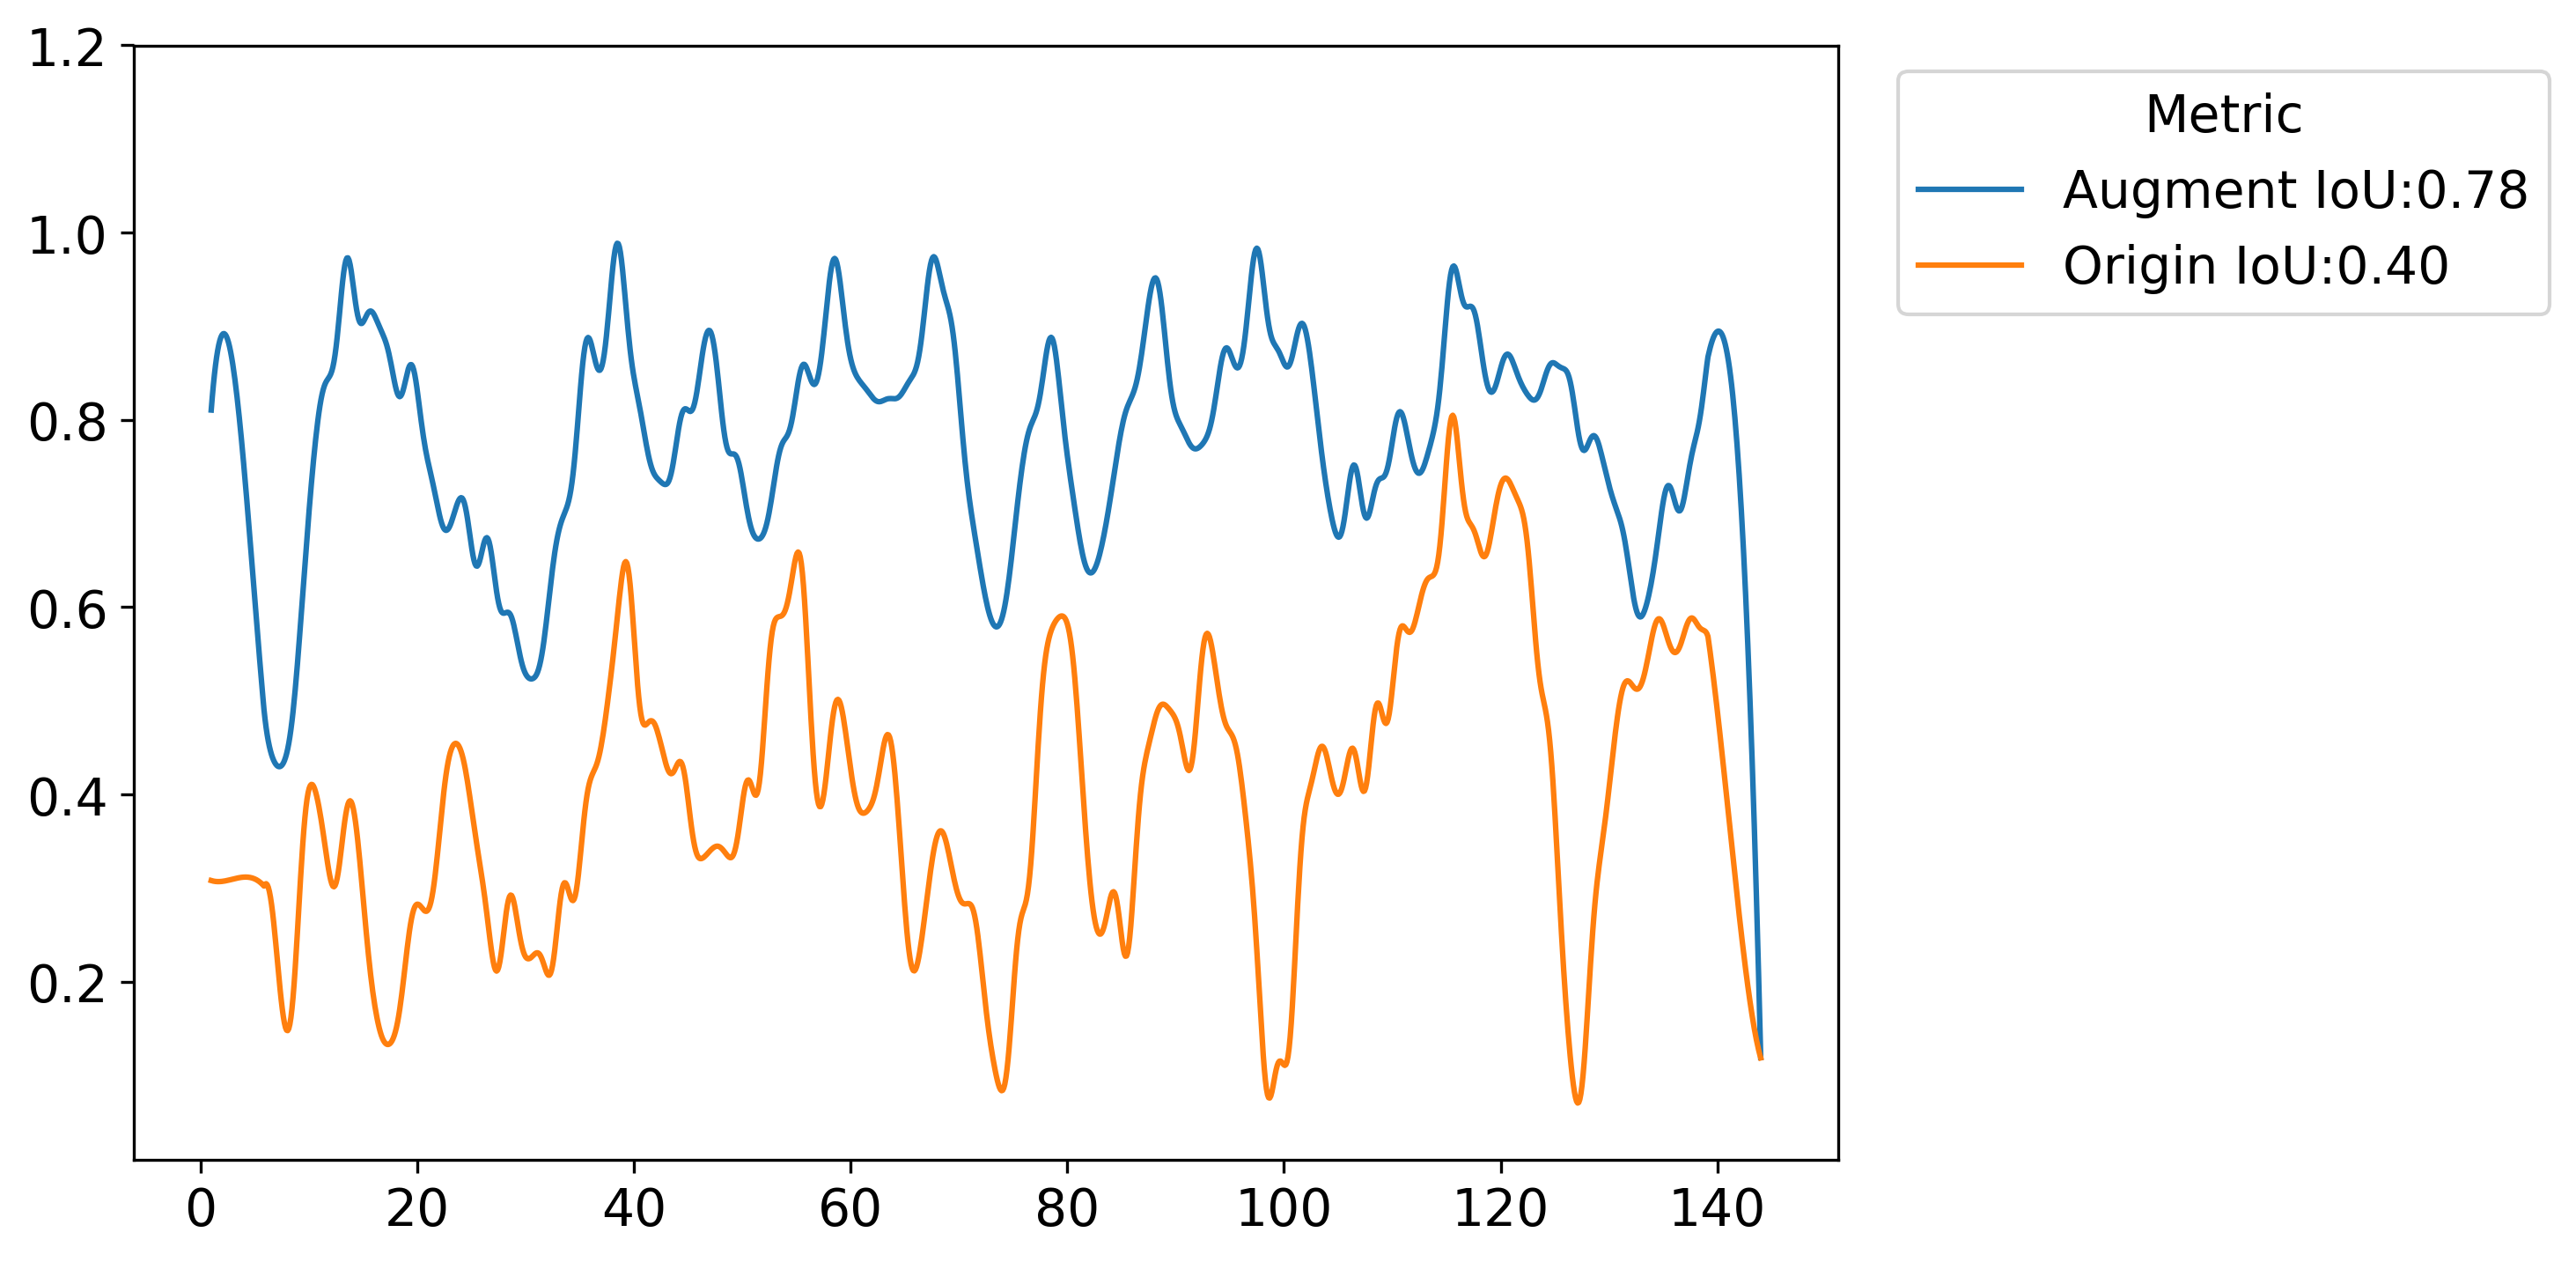

In [89]:
# 繪製 IoU 結果

csv_record_n
csv_record_o
from scipy import interpolate
import matplotlib as mpl
start=6

ax=plt.figure(figsize=(10,5))
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 14
x = np.linspace(1, len(csv_record_n[start:]), num=len(csv_record_n[start:]))
x_new = np.linspace(1, len(csv_record_n[start:]), len(csv_record_n[start:])*10)

bspline = interpolate.make_interp_spline(x, csv_record_n[start:])
y_new = bspline(x_new)
plt.plot(x_new, savgol_filter(y_new, 99, 3), label='Augment IoU:{:.2f}'.format(sum(y_new)/len(y_new)))

bspline = interpolate.make_interp_spline(x, csv_record_o[start:])
y_new = bspline(x_new)
plt.plot(x_new, savgol_filter(y_new, 99, 3), label='Origin IoU:{:.2f}'.format(sum(y_new)/len(y_new)))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Metric')
plt.ylim([0.01,1.2])
plt.tight_layout()
plt.savefig("./iou_比較結果.png")
plt.show()



In [46]:
for stem in aa:
    shutil.copy2(f"D:\\Git\\zjpj\\data_clean\\NOT_IN_the_real593_DATASET\\{stem}.png",
                f"D:\\Git\\zjpj\\data_clean\\IoU_test_image\\{stem}.png")

In [20]:
aa = glob("./data_clean/yolo_label_NOT_IN_the_real593_DATASET/*.*")
aa.pop()
for _ in aa:
    my_stem = Path(_).stem
    
    shutil.copy2(f"D:\\Git\\zjpj\\data_clean\\NOT_IN_the_real593_DATASET\\{my_stem}.png",
                f"D:\\Git\\zjpj\\data_clean\\all_Iou_test\\IoU_test_image\\{my_stem}.png")
    
    

In [44]:
for _ in bad_image:
    stem = Path(_).stem
    os.remove(f"D:\\Git\\zjpj\\data_clean\\IoU_test_image\\{stem}.png")
    os.remove(f"D:\\Git\\zjpj\\data_clean\\IoU_test_image_label\\{stem}.txt")

In [30]:
A = glob("./data_clean/IoU_test_image/*.*")
A = [Path(_).stem for _ in A]
#

for _ in A :
    fpth =f"D:\\Git\\zjpj\\data_clean\\IoU_test_image_label\\{_}.txt"
    if os.path.exists(fpth) == False:
        os.remove(f"D:\\Git\\zjpj\\data_clean\\IoU_test_image\\{_}.png")
    

In [11]:
 # window size 51, polynomial order 3

NameError: name 'y' is not defined

In [45]:
aa = ['00004',
'00005',
'00006',
'00008',
'00015',
'00018',
'00027',
'00032',
'00044',
'00045',
'00049',
'00050',
'00053',
'00054',
'00061',
'00065',
'00067',
'00069',
'00074',
'00078',
'00083',
'00085',
'00087',
'00088',
'00092',
'00100',
'00103',
'00114',
'00115',
'00124',
'00131',
'00134',
'00136',
'00137',
'00139',
'00143',
'00144',
'00150',
'00154',
'00158',
'00160',
'00165',
'00174',
'00177',
'00178',
'00181',
'00184',
'00187',
'00189',
'00196',
'00198',
'00200',
'00203',
'00204',
'00205',
'00208',
'00210',
'00211',
'00216',
'00217',
'00219',
'00224',
'00237',
'00238',
'00239',
'00241',
'00252',
'00256',
'00258',
'00262',
'00264',
'00269',
'00297',
'00299',
'00304',
'00310',
'00328',
'00329',
'00333',
'00335',
'00349',
'00356',
'00365',
'00368',
'00371',
'00383',
'00423',
'00433',
'00440',
'00446',
'00455',
'00458',
'00461',
'00470',
'00487',
'00489',
'00497',
'00500',
'00510',
'00517',
'00522',
'00523',
'00533',
'00536',
'00539',
'00545',
'00549',
'00564',
'00566',
'00584',
'00595',
'00598',
'00609',
'00621',
'00624',
'00632',
'00641',
'00644',
'00651',
'00657',
'00685',
'00689',
'00708',
'00709',
'00713',
'00719',
'00730',
'00748',
'00779',
'00794',
'00795',
'00800',
'00802',
'00805',
'00811',
'00815',
'00816',
'00833',
'00837',
'00841',
'00870',
'00875',
'00889',
'01477',
'01488',
'01491',
'01493',
'01495',
'01498',
'01502']